🚀 Starting Predictive Maintenance ML Pipeline
🔍 Loading and Exploring Dataset...
📊 Dataset Shape: (10000, 14)
📋 Columns: ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

📈 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure

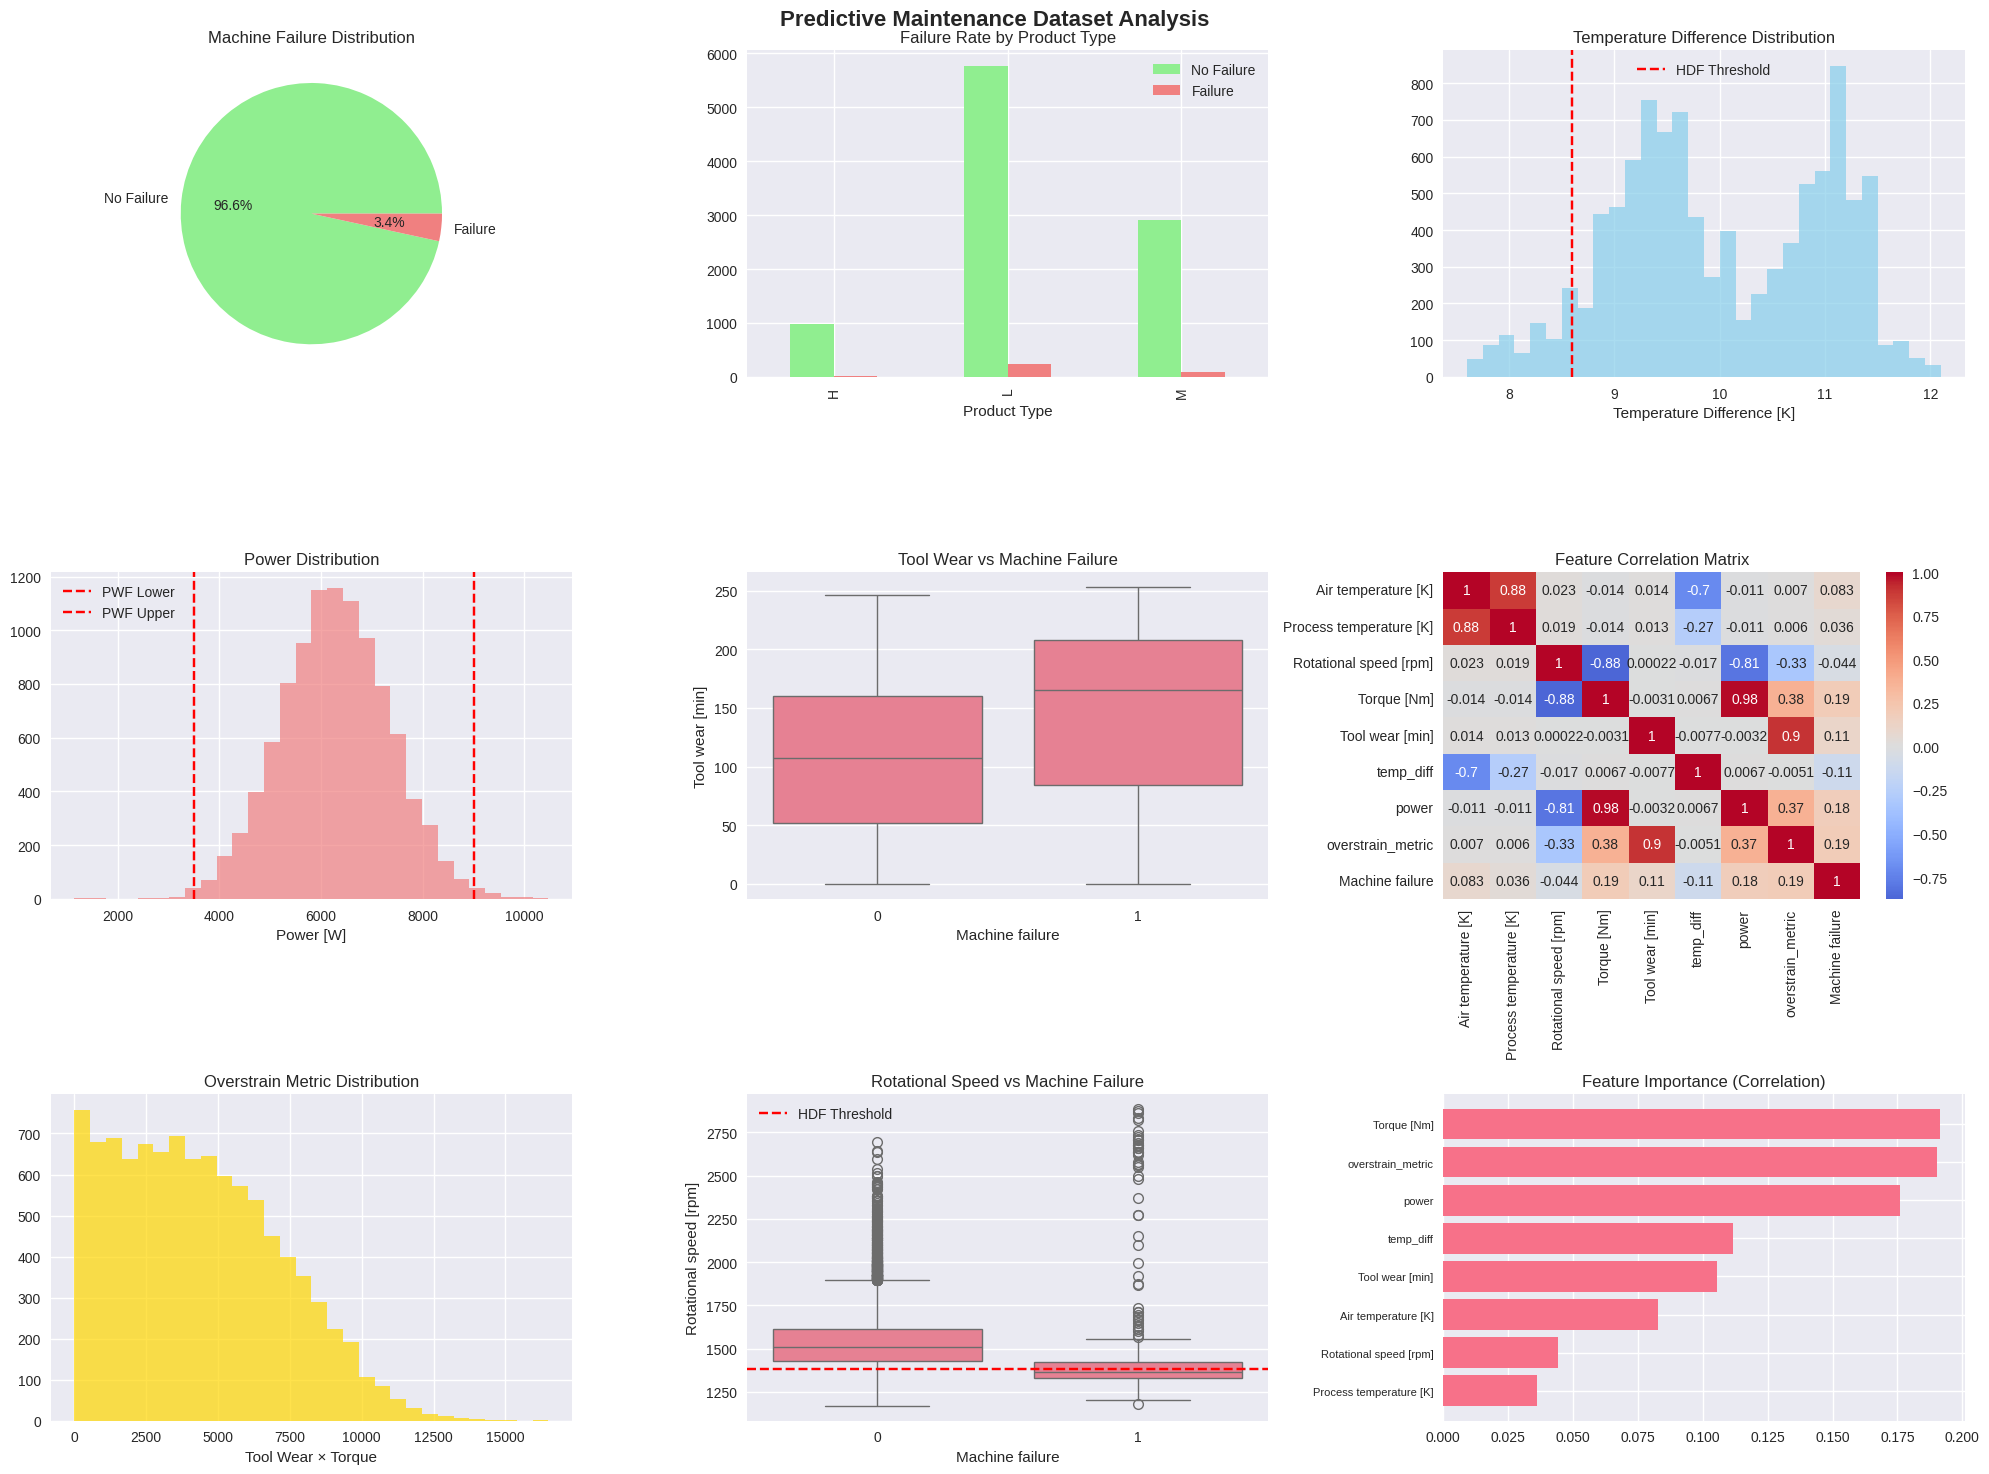


🔧 Preparing Features for Modeling...
✅ Selected 18 features for modeling
📊 Class distribution: {0: 9661, 1: 339}

🤖 Training Multiple Models...

🔄 Training Random Forest...
✅ Random Forest - Accuracy: 0.9800, F1: 0.7436, ROC-AUC: 0.9696

🔄 Training Gradient Boosting...
✅ Gradient Boosting - Accuracy: 0.9665, F1: 0.6455, ROC-AUC: 0.9703

🔄 Training Logistic Regression...
✅ Logistic Regression - Accuracy: 0.8745, F1: 0.3235, ROC-AUC: 0.9458

🔄 Training SVM...
✅ SVM - Accuracy: 0.9450, F1: 0.5339, ROC-AUC: 0.9773

🏆 Best Model: Random Forest (F1 Score: 0.7436)

📊 Model Evaluation...

📈 Model Comparison:
                 Model  Accuracy  F1 Score  ROC-AUC  CV Mean  CV Std
0        Random Forest    0.9800    0.7436   0.9696   0.9905  0.0020
1    Gradient Boosting    0.9665    0.6455   0.9703   0.9732  0.0033
2  Logistic Regression    0.8745    0.3235   0.9458   0.8914  0.0043
3                  SVM    0.9450    0.5339   0.9773   0.9528  0.0035


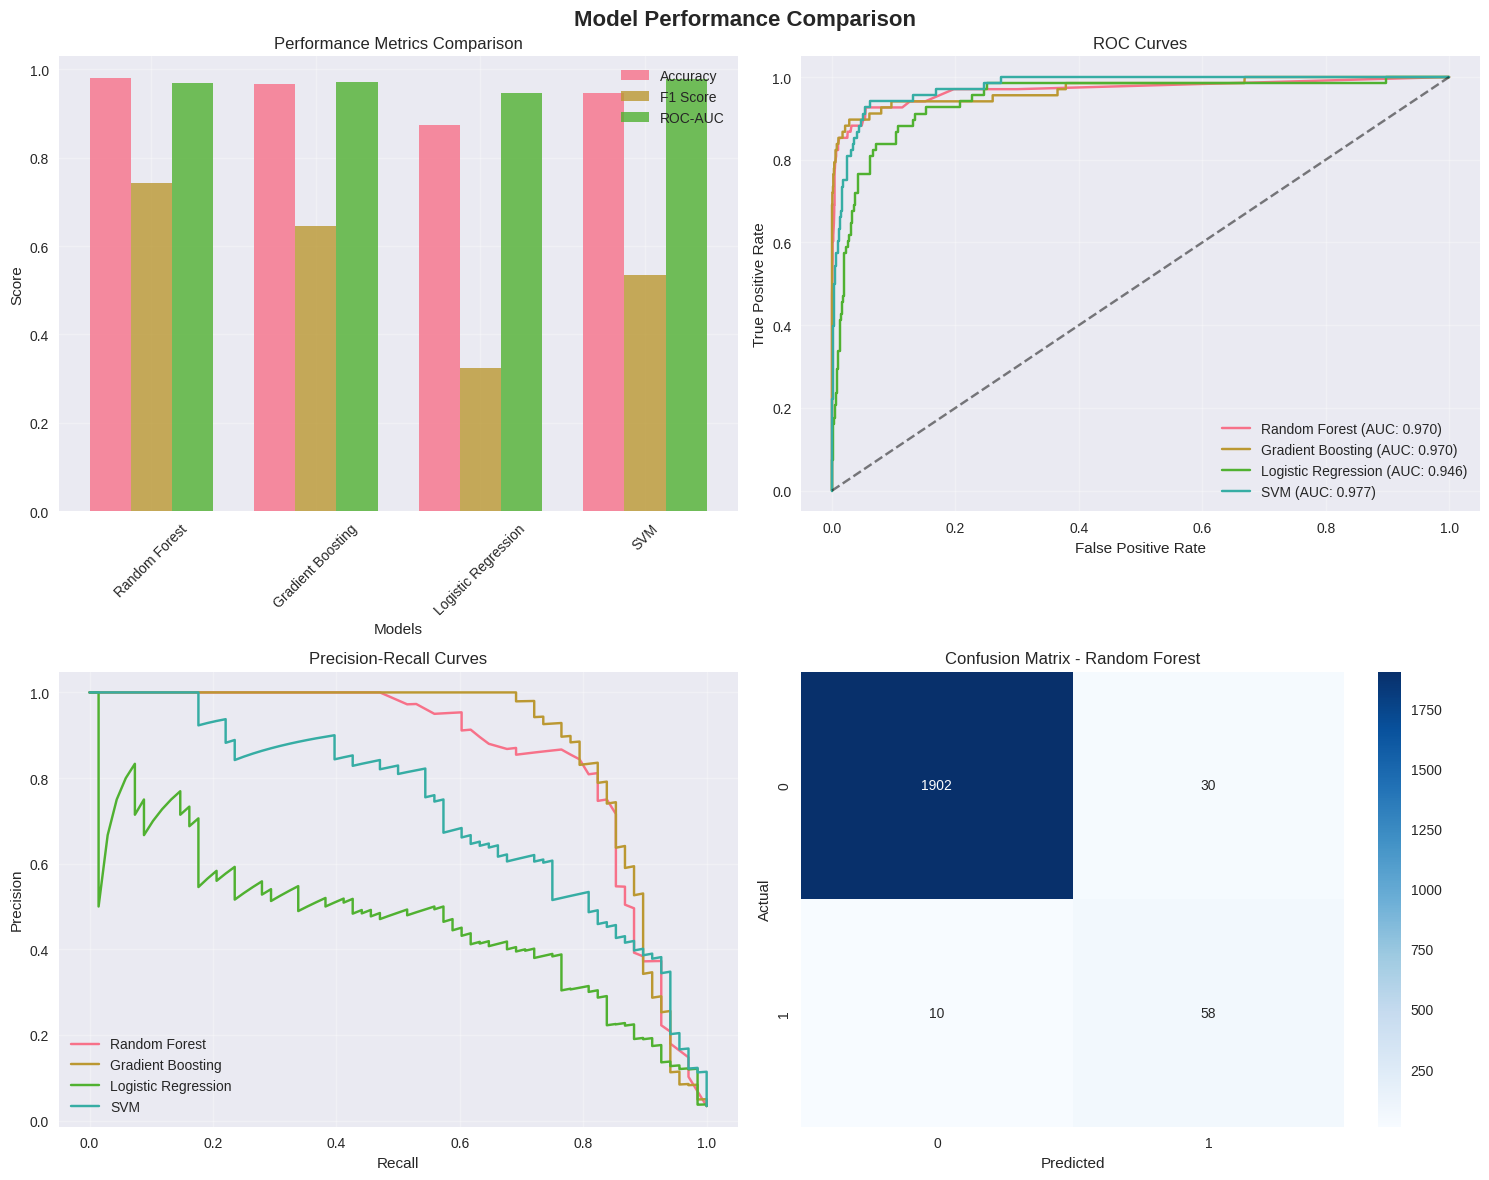


📋 Detailed Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1932
           1       0.66      0.85      0.74        68

    accuracy                           0.98      2000
   macro avg       0.83      0.92      0.87      2000
weighted avg       0.98      0.98      0.98      2000


🔍 Feature Importance Analysis...
🌳 Random Forest Feature Importance:
                   feature  importance
2   Rotational speed [rpm]    0.131924
3              Torque [Nm]    0.131800
4          Tool wear [min]    0.124195
7                    power    0.114407
9         efficiency_ratio    0.091672
8        overstrain_metric    0.089677
6                temp_diff    0.073112
14           speed_cat_Low    0.062218
0      Air temperature [K]    0.038519
5             Type_encoded    0.024290


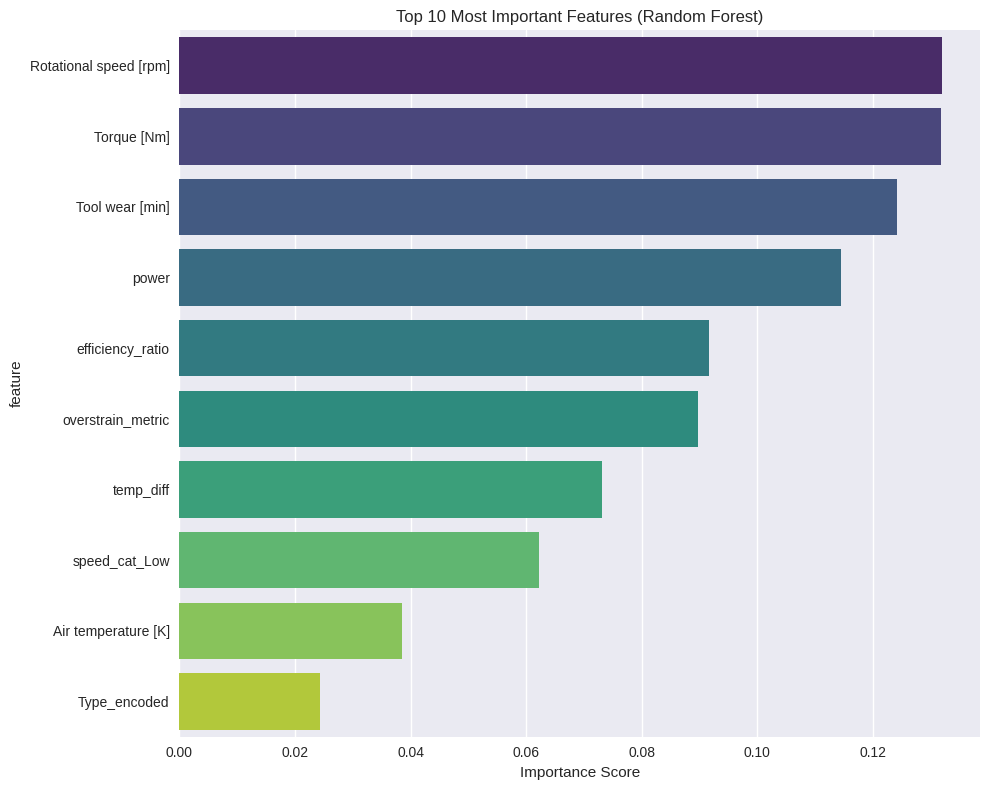


🔮 Making Prediction...
🎯 Prediction: NO FAILURE
📊 Failure Probability: 0.020
🎚️ Risk Level: LOW


In [ ]:
# Predictive Maintenance: Machine Failure Prediction
# Dataset: AI4I 2020 Predictive Maintenance Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class PredictiveMaintenanceML:
    def __init__(self):
        self.models = {}
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_names = []
        self.best_model = None
        self.best_model_name = ""

    def load_and_explore_data(self, filepath):
        """Load dataset and perform initial exploration"""
        print("🔍 Loading and Exploring Dataset...")

        # Load data
        self.df = pd.read_csv(filepath)

        print(f"📊 Dataset Shape: {self.df.shape}")
        print(f"📋 Columns: {list(self.df.columns)}")
        print("\n" + "="*50)

        # Display basic info
        print("📈 Dataset Info:")
        print(self.df.info())
        print("\n" + "="*50)

        # Check for missing values
        print("❓ Missing Values:")
        print(self.df.isnull().sum())
        print("\n" + "="*50)

        # Basic statistics
        print("📊 Statistical Summary:")
        print(self.df.describe())

        return self.df

    def feature_engineering(self):
        """Create new features based on domain knowledge"""
        print("\n🔧 Feature Engineering...")

        # Create a copy for feature engineering
        df_engineered = self.df.copy()

        # 1. Temperature difference (critical for Heat Dissipation Failure)
        df_engineered['temp_diff'] = df_engineered['Process temperature [K]'] - df_engineered['Air temperature [K]']

        # 2. Power calculation (critical for Power Failure)
        # Power = Torque × Angular velocity (in rad/s)
        # Angular velocity = RPM × 2π/60
        df_engineered['power'] = (df_engineered['Torque [Nm]'] *
                                 df_engineered['Rotational speed [rpm]'] * 2 * np.pi / 60)

        # 3. Overstrain metric (critical for Overstrain Failure)
        df_engineered['overstrain_metric'] = df_engineered['Tool wear [min]'] * df_engineered['Torque [Nm]']

        # 4. Tool wear risk zones
        df_engineered['tool_wear_risk'] = pd.cut(df_engineered['Tool wear [min]'],
                                                bins=[0, 100, 180, 220, 300],
                                                labels=['Low', 'Medium', 'High', 'Critical'])

        # 5. Speed categories
        df_engineered['speed_category'] = pd.cut(df_engineered['Rotational speed [rpm]'],
                                               bins=[0, 1380, 1600, 2000, 3000],
                                               labels=['Low', 'Medium', 'High', 'Very_High'])

        # 6. Process efficiency ratio
        df_engineered['efficiency_ratio'] = df_engineered['power'] / df_engineered['Process temperature [K]']

        # 7. Encode categorical variables
        df_engineered['Type_encoded'] = self.label_encoder.fit_transform(df_engineered['Type'])

        # Convert categorical features to dummy variables
        df_engineered = pd.get_dummies(df_engineered, columns=['tool_wear_risk', 'speed_category'],
                                     prefix=['wear_risk', 'speed_cat'])

        self.df_engineered = df_engineered
        print(f"✅ Feature engineering complete. New shape: {df_engineered.shape}")

        return df_engineered

    def visualize_data(self):
        """Create comprehensive visualizations"""
        print("\n📊 Creating Visualizations...")

        # Set up the plotting area
        fig, axes = plt.subplots(3, 3, figsize=(20, 15))
        fig.suptitle('Predictive Maintenance Dataset Analysis', fontsize=16, fontweight='bold')

        # 1. Failure distribution
        failure_counts = self.df['Machine failure'].value_counts()
        axes[0,0].pie(failure_counts.values, labels=['No Failure', 'Failure'], autopct='%1.1f%%',
                     colors=['lightgreen', 'lightcoral'])
        axes[0,0].set_title('Machine Failure Distribution')

        # 2. Failure by Type
        failure_by_type = pd.crosstab(self.df['Type'], self.df['Machine failure'])
        failure_by_type.plot(kind='bar', ax=axes[0,1], color=['lightgreen', 'lightcoral'])
        axes[0,1].set_title('Failure Rate by Product Type')
        axes[0,1].set_xlabel('Product Type')
        axes[0,1].legend(['No Failure', 'Failure'])

        # 3. Temperature difference distribution
        axes[0,2].hist(self.df_engineered['temp_diff'], bins=30, alpha=0.7, color='skyblue')
        axes[0,2].axvline(8.6, color='red', linestyle='--', label='HDF Threshold')
        axes[0,2].set_title('Temperature Difference Distribution')
        axes[0,2].set_xlabel('Temperature Difference [K]')
        axes[0,2].legend()

        # 4. Power distribution
        axes[1,0].hist(self.df_engineered['power'], bins=30, alpha=0.7, color='lightcoral')
        axes[1,0].axvline(3500, color='red', linestyle='--', label='PWF Lower')
        axes[1,0].axvline(9000, color='red', linestyle='--', label='PWF Upper')
        axes[1,0].set_title('Power Distribution')
        axes[1,0].set_xlabel('Power [W]')
        axes[1,0].legend()

        # 5. Tool wear vs Failure
        sns.boxplot(data=self.df, x='Machine failure', y='Tool wear [min]', ax=axes[1,1])
        axes[1,1].set_title('Tool Wear vs Machine Failure')

        # 6. Correlation heatmap
        numeric_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
                       'Torque [Nm]', 'Tool wear [min]', 'temp_diff', 'power', 'overstrain_metric']
        correlation_matrix = self.df_engineered[numeric_cols + ['Machine failure']].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
        axes[1,2].set_title('Feature Correlation Matrix')

        # 7. Overstrain metric distribution
        axes[2,0].hist(self.df_engineered['overstrain_metric'], bins=30, alpha=0.7, color='gold')
        axes[2,0].set_title('Overstrain Metric Distribution')
        axes[2,0].set_xlabel('Tool Wear × Torque')

        # 8. Rotational speed vs failure
        sns.boxplot(data=self.df, x='Machine failure', y='Rotational speed [rpm]', ax=axes[2,1])
        axes[2,1].axhline(1380, color='red', linestyle='--', label='HDF Threshold')
        axes[2,1].set_title('Rotational Speed vs Machine Failure')
        axes[2,1].legend()

        # 9. Feature importance preview (using correlation with target)
        feature_importance = abs(correlation_matrix['Machine failure'].drop('Machine failure')).sort_values(ascending=True)
        axes[2,2].barh(range(len(feature_importance)), feature_importance.values)
        axes[2,2].set_yticks(range(len(feature_importance)))
        axes[2,2].set_yticklabels(feature_importance.index, fontsize=8)
        axes[2,2].set_title('Feature Importance (Correlation)')

        plt.tight_layout()
        plt.show()

    def prepare_features(self):
        """Prepare features for modeling"""
        print("\n🔧 Preparing Features for Modeling...")

        # Select features for modeling
        feature_cols = [
            'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
            'Torque [Nm]', 'Tool wear [min]', 'Type_encoded',
            'temp_diff', 'power', 'overstrain_metric', 'efficiency_ratio'
        ]

        # Add dummy variables
        dummy_cols = [col for col in self.df_engineered.columns if 'wear_risk_' in col or 'speed_cat_' in col]
        feature_cols.extend(dummy_cols)

        # Prepare X and y
        X = self.df_engineered[feature_cols]
        y = self.df_engineered['Machine failure']

        self.feature_names = feature_cols

        print(f"✅ Selected {len(feature_cols)} features for modeling")
        print(f"📊 Class distribution: {y.value_counts().to_dict()}")

        return X, y

    def train_models(self, X, y, test_size=0.2, random_state=42):
        """Train multiple models and compare performance"""
        print("\n🤖 Training Multiple Models...")

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Store test data for later use
        self.X_test = X_test_scaled
        self.y_test = y_test

        # Define models
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=random_state),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=random_state),
            'Logistic Regression': LogisticRegression(random_state=random_state, max_iter=1000),
            'SVM': SVC(probability=True, random_state=random_state)
        }

        # Train models and evaluate
        results = {}

        for name, model in models.items():
            print(f"\n🔄 Training {name}...")

            # Handle class imbalance with SMOTE
            smote = SMOTE(random_state=random_state)
            X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

            # Train model
            model.fit(X_train_balanced, y_train_balanced)

            # Make predictions
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred_proba)

            # Cross-validation
            cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=5, scoring='f1')

            results[name] = {
                'model': model,
                'accuracy': accuracy,
                'f1_score': f1,
                'roc_auc': roc_auc,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }

            print(f"✅ {name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

        self.models = results

        # Find best model based on F1 score (better for imbalanced data)
        best_model_name = max(results.keys(), key=lambda x: results[x]['f1_score'])
        self.best_model = results[best_model_name]['model']
        self.best_model_name = best_model_name

        print(f"\n🏆 Best Model: {best_model_name} (F1 Score: {results[best_model_name]['f1_score']:.4f})")

        return results

    def evaluate_models(self):
        """Comprehensive model evaluation"""
        print("\n📊 Model Evaluation...")

        # Create comparison DataFrame
        comparison_data = []
        for name, result in self.models.items():
            comparison_data.append({
                'Model': name,
                'Accuracy': result['accuracy'],
                'F1 Score': result['f1_score'],
                'ROC-AUC': result['roc_auc'],
                'CV Mean': result['cv_mean'],
                'CV Std': result['cv_std']
            })

        comparison_df = pd.DataFrame(comparison_data)
        print("\n📈 Model Comparison:")
        print(comparison_df.round(4))

        # Visualize results
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

        # 1. Metrics comparison
        metrics = ['Accuracy', 'F1 Score', 'ROC-AUC']
        x = np.arange(len(comparison_df))
        width = 0.25

        for i, metric in enumerate(metrics):
            axes[0,0].bar(x + i*width, comparison_df[metric], width, label=metric, alpha=0.8)

        axes[0,0].set_xlabel('Models')
        axes[0,0].set_ylabel('Score')
        axes[0,0].set_title('Performance Metrics Comparison')
        axes[0,0].set_xticks(x + width)
        axes[0,0].set_xticklabels(comparison_df['Model'], rotation=45)
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # 2. ROC Curves
        for name, result in self.models.items():
            fpr, tpr, _ = roc_curve(self.y_test, result['probabilities'])
            axes[0,1].plot(fpr, tpr, label=f"{name} (AUC: {result['roc_auc']:.3f})")

        axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
        axes[0,1].set_xlabel('False Positive Rate')
        axes[0,1].set_ylabel('True Positive Rate')
        axes[0,1].set_title('ROC Curves')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

        # 3. Precision-Recall Curves
        for name, result in self.models.items():
            precision, recall, _ = precision_recall_curve(self.y_test, result['probabilities'])
            axes[1,0].plot(recall, precision, label=f"{name}")

        axes[1,0].set_xlabel('Recall')
        axes[1,0].set_ylabel('Precision')
        axes[1,0].set_title('Precision-Recall Curves')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

        # 4. Confusion Matrix for Best Model
        cm = confusion_matrix(self.y_test, self.models[self.best_model_name]['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1])
        axes[1,1].set_title(f'Confusion Matrix - {self.best_model_name}')
        axes[1,1].set_xlabel('Predicted')
        axes[1,1].set_ylabel('Actual')

        plt.tight_layout()
        plt.show()

        # Detailed classification report for best model
        print(f"\n📋 Detailed Classification Report - {self.best_model_name}:")
        print(classification_report(self.y_test, self.models[self.best_model_name]['predictions']))

    def feature_importance_analysis(self):
        """Analyze feature importance for tree-based models"""
        print("\n🔍 Feature Importance Analysis...")

        # Get feature importance from Random Forest
        if 'Random Forest' in self.models:
            rf_model = self.models['Random Forest']['model']
            feature_importance = pd.DataFrame({
                'feature': self.feature_names,
                'importance': rf_model.feature_importances_
            }).sort_values('importance', ascending=False)

            print("🌳 Random Forest Feature Importance:")
            print(feature_importance.head(10))

            # Plot feature importance
            plt.figure(figsize=(10, 8))
            sns.barplot(data=feature_importance.head(10), y='feature', x='importance', palette='viridis')
            plt.title('Top 10 Most Important Features (Random Forest)')
            plt.xlabel('Importance Score')
            plt.tight_layout()
            plt.show()

            return feature_importance

    def predict_maintenance(self, input_data):
        """Make predictions for new data"""
        """
        Expected input_data format (dict):
        {
            'Air temperature [K]': 298.1,
            'Process temperature [K]': 308.6,
            'Rotational speed [rpm]': 1551,
            'Torque [Nm]': 42.8,
            'Tool wear [min]': 0,
            'Type': 'M'  # L, M, or H
        }
        """
        print("\n🔮 Making Prediction...")

        # Convert input to DataFrame
        input_df = pd.DataFrame([input_data])

        # Apply same feature engineering
        input_df['Type_encoded'] = self.label_encoder.transform(input_df['Type'])
        input_df['temp_diff'] = input_df['Process temperature [K]'] - input_df['Air temperature [K]']
        input_df['power'] = (input_df['Torque [Nm]'] * input_df['Rotational speed [rpm]'] * 2 * np.pi / 60)
        input_df['overstrain_metric'] = input_df['Tool wear [min]'] * input_df['Torque [Nm]']
        input_df['efficiency_ratio'] = input_df['power'] / input_df['Process temperature [K]']

        # Create dummy variables (set all to 0 for simplicity, can be enhanced)
        for col in self.feature_names:
            if col not in input_df.columns:
                input_df[col] = 0

        # Select and order features
        X_input = input_df[self.feature_names]

        # Scale features
        X_input_scaled = self.scaler.transform(X_input)

        # Make prediction
        prediction = self.best_model.predict(X_input_scaled)[0]
        probability = self.best_model.predict_proba(X_input_scaled)[0]

        # Detailed analysis
        result = {
            'prediction': 'FAILURE EXPECTED' if prediction == 1 else 'NO FAILURE',
            'failure_probability': probability[1],
            'confidence': max(probability),
            'risk_level': 'HIGH' if probability[1] > 0.7 else 'MEDIUM' if probability[1] > 0.3 else 'LOW'
        }

        print(f"🎯 Prediction: {result['prediction']}")
        print(f"📊 Failure Probability: {result['failure_probability']:.3f}")
        print(f"🎚️ Risk Level: {result['risk_level']}")

        return result

# Example usage and demonstration
if __name__ == "__main__":
    # Initialize the ML pipeline
    pm_ml = PredictiveMaintenanceML()

    # Note: Replace 'your_dataset.csv' with the actual path to your dataset
    print("🚀 Starting Predictive Maintenance ML Pipeline")
    print("=" * 60)

    # Uncomment the following lines when you have the dataset

    # Load and explore data
    df = pm_ml.load_and_explore_data('/content/ai4i2020.csv')

    # Feature engineering
    df_engineered = pm_ml.feature_engineering()

    # Create visualizations
    pm_ml.visualize_data()

    # Prepare features
    X, y = pm_ml.prepare_features()

    # Train models
    results = pm_ml.train_models(X, y)

    # Evaluate models
    pm_ml.evaluate_models()

    # Feature importance analysis
    feature_importance = pm_ml.feature_importance_analysis()

    # Example prediction
    sample_input = {
        'Air temperature [K]': 298.1,
        'Process temperature [K]': 308.6,
        'Rotational speed [rpm]': 1551,
        'Torque [Nm]': 42.8,
        'Tool wear [min]': 0,
        'Type': 'M'
    }

    prediction_result = pm_ml.predict_maintenance(sample_input)




🚀 Starting Predictive Maintenance ML Pipeline
🔍 Loading Dataset...
✅ Dataset loaded successfully - Shape: (10000, 14)

🔧 Feature Engineering...
✅ Feature engineering complete. New shape: (10000, 27)

📊 Creating Visualizations...


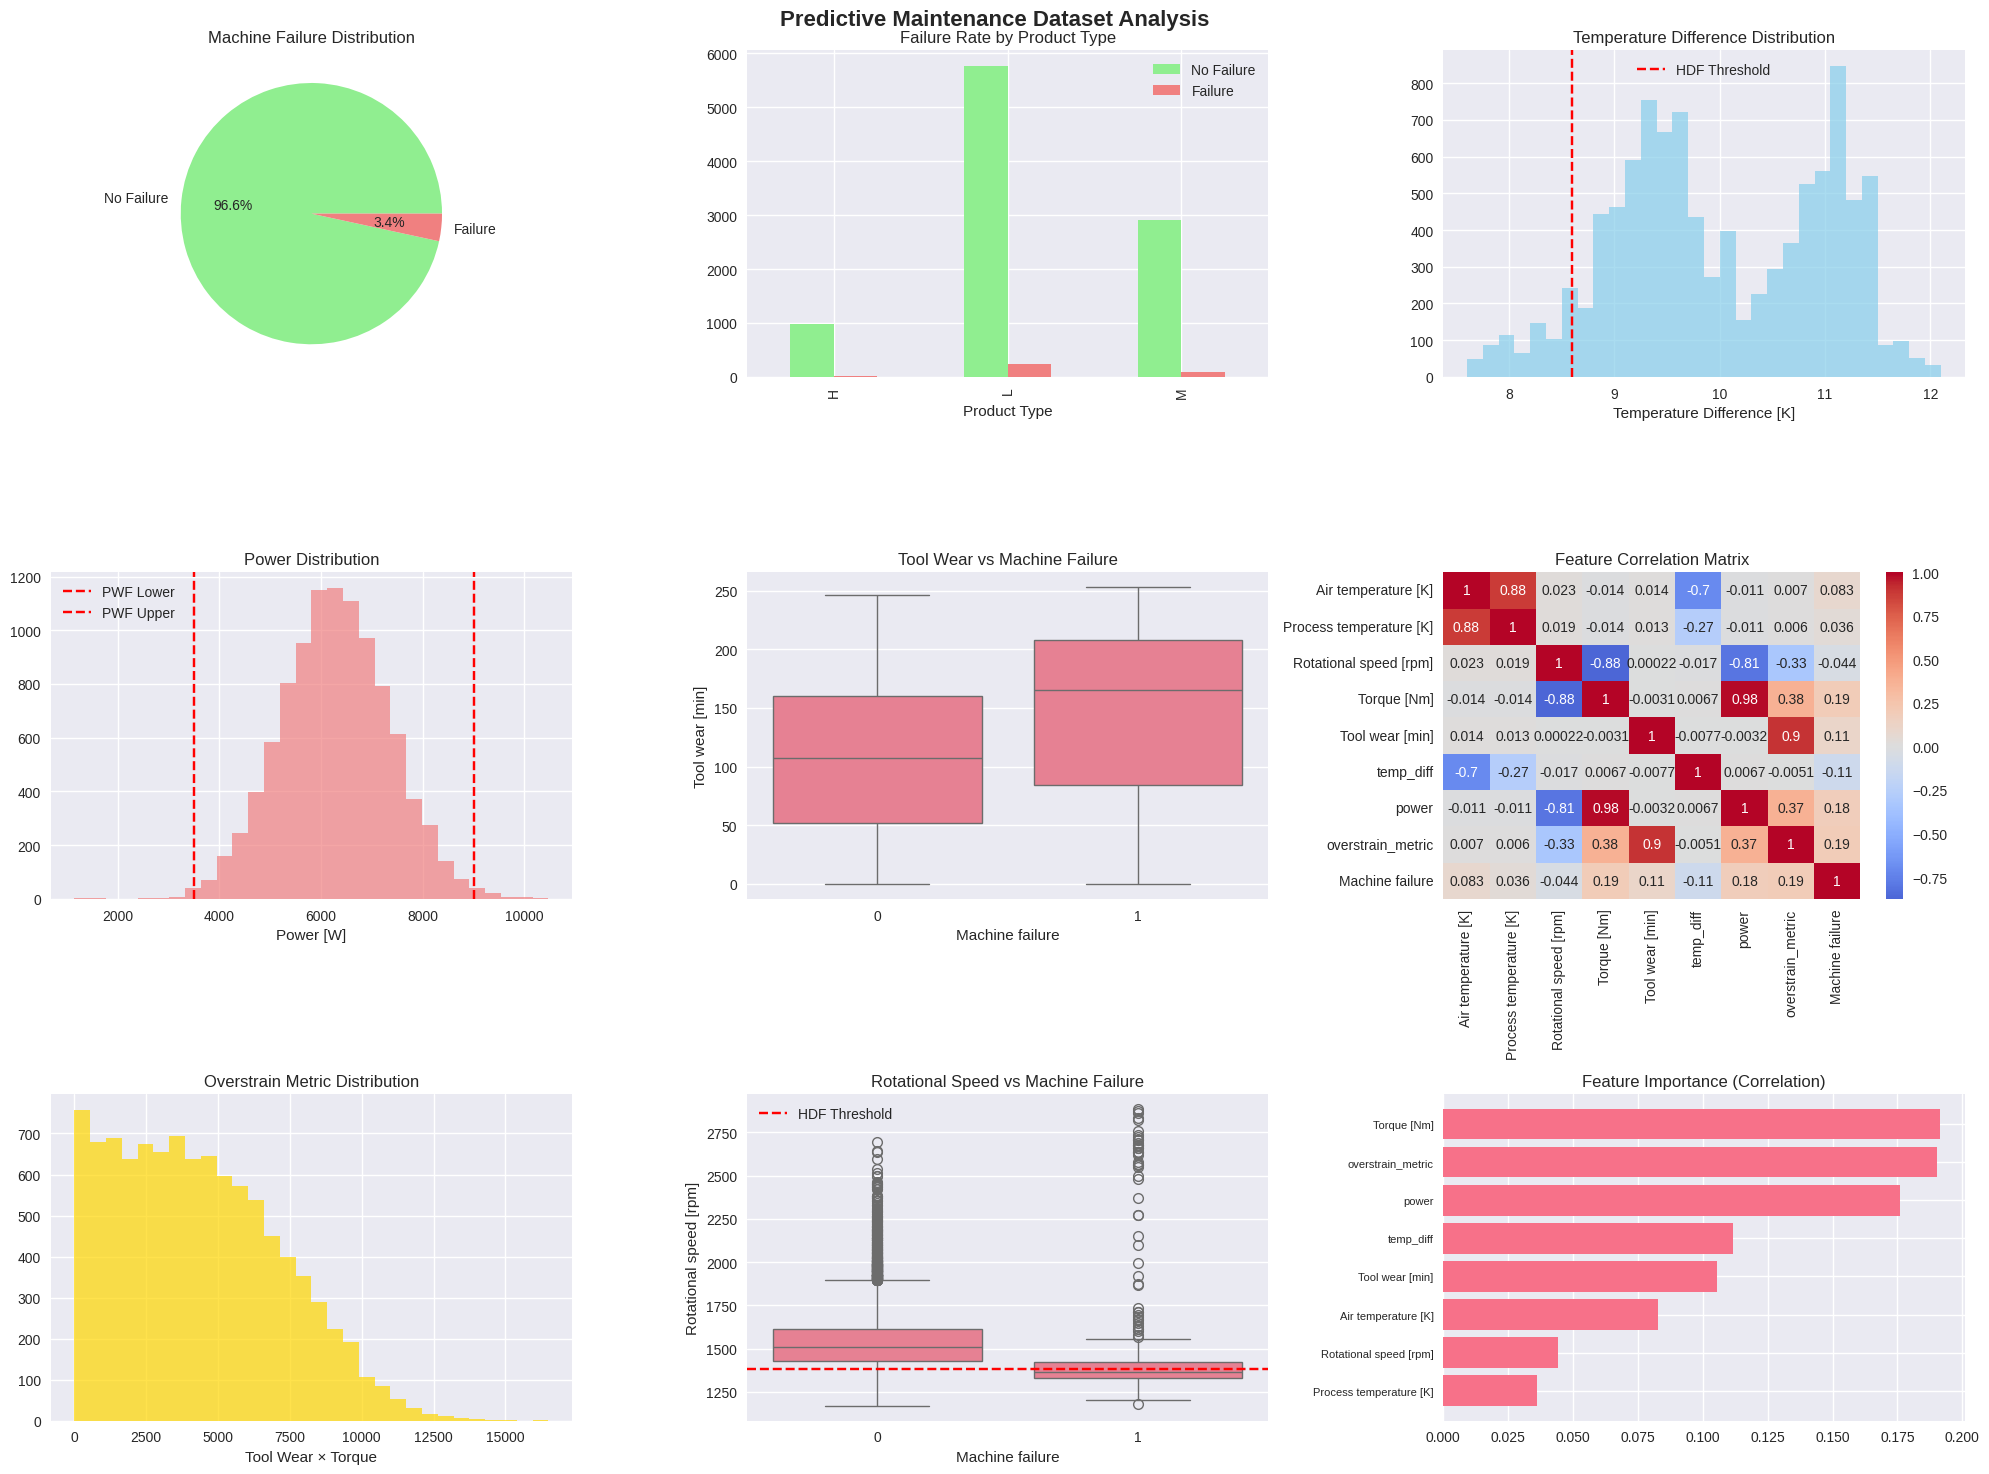


🔧 Preparing Features for Modeling...
✅ Selected 18 features for modeling
📊 Class distribution: {0: 9661, 1: 339}

🤖 Training and Selecting Best Model...
🏆 Best Model Selected: Random Forest
📊 Performance - Accuracy: 0.9800, F1: 0.7436, ROC-AUC: 0.9696

📊 MODEL PERFORMANCE SUMMARY
🏆 Best Model: Random Forest
🎯 Accuracy: 98.00%
📈 F1-Score: 0.7436
📊 ROC-AUC: 0.9696

🔍 DETAILED RESULTS:
✅ True Negatives (Correctly predicted No Failure): 1902
❌ False Positives (Incorrectly predicted Failure): 30
❌ False Negatives (Missed Failures): 10
✅ True Positives (Correctly predicted Failure): 58

📋 KEY METRICS:
🔍 Precision (When predicting failure, how often correct): 65.91%
🎯 Recall (How many actual failures detected): 85.29%


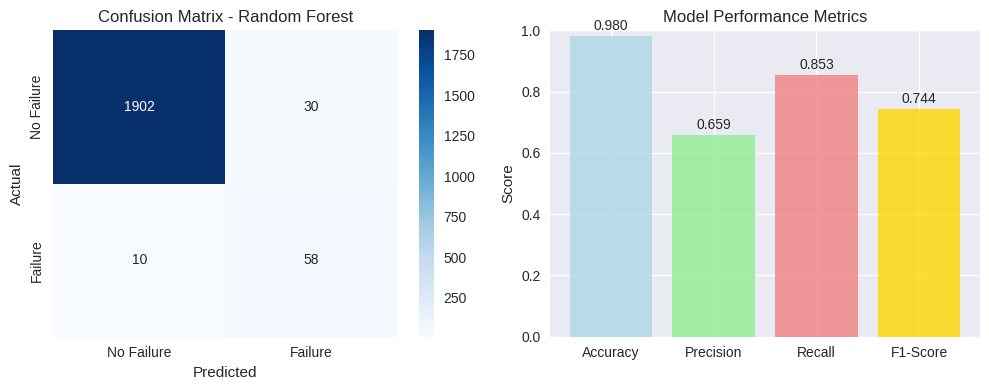


🔍 Feature Importance Analysis...

🔮 MACHINE FAILURE PREDICTION
📋 INPUT PARAMETERS:
   🌡️  Air Temperature: 298.1 K
   🔥 Process Temperature: 308.6 K
   ⚙️  Rotational Speed: 1551 rpm
   🔧 Torque: 42.8 Nm
   ⏰ Tool Wear: 0 minutes
   📦 Product Type: M

🔍 CALCULATED METRICS:
   🌡️  Temperature Difference: 10.5 K
   ⚡ Power: 6952 W
   💪 Overstrain Metric: 0 min·Nm

🎯 PREDICTION RESULT:
✅ NO FAILURE EXPECTED
📊 Failure Probability: 2.0%
🎚️  Risk Level: 🟢 LOW
🎯 Confidence: 98.0%

✅ NO MAJOR RISK FACTORS IDENTIFIED

💡 RECOMMENDATIONS:
   ✅ Continue normal operation
   📊 Regular monitoring recommended


In [ ]:
# Predictive Maintenance: Machine Failure Prediction
# Dataset: AI4I 2020 Predictive Maintenance Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class PredictiveMaintenanceML:
    def __init__(self):
        self.models = {}
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_names = []
        self.best_model = None
        self.best_model_name = ""

    def load_data(self, filepath):
        """Load dataset"""
        print("🔍 Loading Dataset...")

        # Load data
        self.df = pd.read_csv(filepath)
        print(f"✅ Dataset loaded successfully - Shape: {self.df.shape}")

        return self.df

    def feature_engineering(self):
        """Create new features based on domain knowledge"""
        print("\n🔧 Feature Engineering...")

        # Create a copy for feature engineering
        df_engineered = self.df.copy()

        # 1. Temperature difference (critical for Heat Dissipation Failure)
        df_engineered['temp_diff'] = df_engineered['Process temperature [K]'] - df_engineered['Air temperature [K]']

        # 2. Power calculation (critical for Power Failure)
        # Power = Torque × Angular velocity (in rad/s)
        # Angular velocity = RPM × 2π/60
        df_engineered['power'] = (df_engineered['Torque [Nm]'] *
                                 df_engineered['Rotational speed [rpm]'] * 2 * np.pi / 60)

        # 3. Overstrain metric (critical for Overstrain Failure)
        df_engineered['overstrain_metric'] = df_engineered['Tool wear [min]'] * df_engineered['Torque [Nm]']

        # 4. Tool wear risk zones
        df_engineered['tool_wear_risk'] = pd.cut(df_engineered['Tool wear [min]'],
                                                bins=[0, 100, 180, 220, 300],
                                                labels=['Low', 'Medium', 'High', 'Critical'])

        # 5. Speed categories
        df_engineered['speed_category'] = pd.cut(df_engineered['Rotational speed [rpm]'],
                                               bins=[0, 1380, 1600, 2000, 3000],
                                               labels=['Low', 'Medium', 'High', 'Very_High'])

        # 6. Process efficiency ratio
        df_engineered['efficiency_ratio'] = df_engineered['power'] / df_engineered['Process temperature [K]']

        # 7. Encode categorical variables
        df_engineered['Type_encoded'] = self.label_encoder.fit_transform(df_engineered['Type'])

        # Convert categorical features to dummy variables
        df_engineered = pd.get_dummies(df_engineered, columns=['tool_wear_risk', 'speed_category'],
                                     prefix=['wear_risk', 'speed_cat'])

        self.df_engineered = df_engineered
        print(f"✅ Feature engineering complete. New shape: {df_engineered.shape}")

        return df_engineered

    def visualize_data(self):
        """Create comprehensive visualizations"""
        print("\n📊 Creating Visualizations...")

        # Set up the plotting area
        fig, axes = plt.subplots(3, 3, figsize=(20, 15))
        fig.suptitle('Predictive Maintenance Dataset Analysis', fontsize=16, fontweight='bold')

        # 1. Failure distribution
        failure_counts = self.df['Machine failure'].value_counts()
        axes[0,0].pie(failure_counts.values, labels=['No Failure', 'Failure'], autopct='%1.1f%%',
                     colors=['lightgreen', 'lightcoral'])
        axes[0,0].set_title('Machine Failure Distribution')

        # 2. Failure by Type
        failure_by_type = pd.crosstab(self.df['Type'], self.df['Machine failure'])
        failure_by_type.plot(kind='bar', ax=axes[0,1], color=['lightgreen', 'lightcoral'])
        axes[0,1].set_title('Failure Rate by Product Type')
        axes[0,1].set_xlabel('Product Type')
        axes[0,1].legend(['No Failure', 'Failure'])

        # 3. Temperature difference distribution
        axes[0,2].hist(self.df_engineered['temp_diff'], bins=30, alpha=0.7, color='skyblue')
        axes[0,2].axvline(8.6, color='red', linestyle='--', label='HDF Threshold')
        axes[0,2].set_title('Temperature Difference Distribution')
        axes[0,2].set_xlabel('Temperature Difference [K]')
        axes[0,2].legend()

        # 4. Power distribution
        axes[1,0].hist(self.df_engineered['power'], bins=30, alpha=0.7, color='lightcoral')
        axes[1,0].axvline(3500, color='red', linestyle='--', label='PWF Lower')
        axes[1,0].axvline(9000, color='red', linestyle='--', label='PWF Upper')
        axes[1,0].set_title('Power Distribution')
        axes[1,0].set_xlabel('Power [W]')
        axes[1,0].legend()

        # 5. Tool wear vs Failure
        sns.boxplot(data=self.df, x='Machine failure', y='Tool wear [min]', ax=axes[1,1])
        axes[1,1].set_title('Tool Wear vs Machine Failure')

        # 6. Correlation heatmap
        numeric_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
                       'Torque [Nm]', 'Tool wear [min]', 'temp_diff', 'power', 'overstrain_metric']
        correlation_matrix = self.df_engineered[numeric_cols + ['Machine failure']].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
        axes[1,2].set_title('Feature Correlation Matrix')

        # 7. Overstrain metric distribution
        axes[2,0].hist(self.df_engineered['overstrain_metric'], bins=30, alpha=0.7, color='gold')
        axes[2,0].set_title('Overstrain Metric Distribution')
        axes[2,0].set_xlabel('Tool Wear × Torque')

        # 8. Rotational speed vs failure
        sns.boxplot(data=self.df, x='Machine failure', y='Rotational speed [rpm]', ax=axes[2,1])
        axes[2,1].axhline(1380, color='red', linestyle='--', label='HDF Threshold')
        axes[2,1].set_title('Rotational Speed vs Machine Failure')
        axes[2,1].legend()

        # 9. Feature importance preview (using correlation with target)
        feature_importance = abs(correlation_matrix['Machine failure'].drop('Machine failure')).sort_values(ascending=True)
        axes[2,2].barh(range(len(feature_importance)), feature_importance.values)
        axes[2,2].set_yticks(range(len(feature_importance)))
        axes[2,2].set_yticklabels(feature_importance.index, fontsize=8)
        axes[2,2].set_title('Feature Importance (Correlation)')

        plt.tight_layout()
        plt.show()

    def prepare_features(self):
        """Prepare features for modeling"""
        print("\n🔧 Preparing Features for Modeling...")

        # Select features for modeling
        feature_cols = [
            'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
            'Torque [Nm]', 'Tool wear [min]', 'Type_encoded',
            'temp_diff', 'power', 'overstrain_metric', 'efficiency_ratio'
        ]

        # Add dummy variables
        dummy_cols = [col for col in self.df_engineered.columns if 'wear_risk_' in col or 'speed_cat_' in col]
        feature_cols.extend(dummy_cols)

        # Prepare X and y
        X = self.df_engineered[feature_cols]
        y = self.df_engineered['Machine failure']

        self.feature_names = feature_cols

        print(f"✅ Selected {len(feature_cols)} features for modeling")
        print(f"📊 Class distribution: {y.value_counts().to_dict()}")

        return X, y

    def train_best_model(self, X, y, test_size=0.2, random_state=42):
        """Train and select the best performing model"""
        print("\n🤖 Training and Selecting Best Model...")

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Store test data for later use
        self.X_test = X_test_scaled
        self.y_test = y_test

        # Define models for quick evaluation
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=random_state),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=random_state),
            'Logistic Regression': LogisticRegression(random_state=random_state, max_iter=1000)
        }

        # Quick evaluation to find best model
        best_f1 = 0
        best_model_name = ""

        for name, model in models.items():
            # Handle class imbalance with SMOTE
            smote = SMOTE(random_state=random_state)
            X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

            # Train model
            model.fit(X_train_balanced, y_train_balanced)

            # Quick evaluation
            y_pred = model.predict(X_test_scaled)
            f1 = f1_score(y_test, y_pred)

            if f1 > best_f1:
                best_f1 = f1
                best_model_name = name
                self.best_model = model

        self.best_model_name = best_model_name

        # Final evaluation of best model
        y_pred = self.best_model.predict(X_test_scaled)
        y_pred_proba = self.best_model.predict_proba(X_test_scaled)[:, 1]

        # Calculate final metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1_final = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        self.model_performance = {
            'accuracy': accuracy,
            'f1_score': f1_final,
            'roc_auc': roc_auc,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

        print(f"🏆 Best Model Selected: {best_model_name}")
        print(f"📊 Performance - Accuracy: {accuracy:.4f}, F1: {f1_final:.4f}, ROC-AUC: {roc_auc:.4f}")

        return self.best_model

    def show_model_performance(self):
        """Display model performance clearly"""
        print("\n📊 MODEL PERFORMANCE SUMMARY")
        print("=" * 50)
        print(f"🏆 Best Model: {self.best_model_name}")
        print(f"🎯 Accuracy: {self.model_performance['accuracy']:.2%}")
        print(f"📈 F1-Score: {self.model_performance['f1_score']:.4f}")
        print(f"📊 ROC-AUC: {self.model_performance['roc_auc']:.4f}")

        # Confusion Matrix Details
        cm = confusion_matrix(self.y_test, self.model_performance['predictions'])
        tn, fp, fn, tp = cm.ravel()

        print(f"\n🔍 DETAILED RESULTS:")
        print(f"✅ True Negatives (Correctly predicted No Failure): {tn}")
        print(f"❌ False Positives (Incorrectly predicted Failure): {fp}")
        print(f"❌ False Negatives (Missed Failures): {fn}")
        print(f"✅ True Positives (Correctly predicted Failure): {tp}")

        # Calculate additional metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        print(f"\n📋 KEY METRICS:")
        print(f"🔍 Precision (When predicting failure, how often correct): {precision:.2%}")
        print(f"🎯 Recall (How many actual failures detected): {recall:.2%}")

        # Simple visualization
        plt.figure(figsize=(10, 4))

        # Confusion Matrix
        plt.subplot(1, 2, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No Failure', 'Failure'],
                   yticklabels=['No Failure', 'Failure'])
        plt.title(f'Confusion Matrix - {self.best_model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        # Performance Metrics Bar Chart
        plt.subplot(1, 2, 2)
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        values = [self.model_performance['accuracy'], precision, recall, self.model_performance['f1_score']]
        colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold']

        bars = plt.bar(metrics, values, color=colors, alpha=0.8)
        plt.title('Model Performance Metrics')
        plt.ylabel('Score')
        plt.ylim(0, 1)

        # Add value labels on bars
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def feature_importance_analysis(self):
        """Analyze feature importance for tree-based models"""
        print("\n🔍 Feature Importance Analysis...")

        # Get feature importance from Random Forest
        if 'Random Forest' in self.models:
            rf_model = self.models['Random Forest']['model']
            feature_importance = pd.DataFrame({
                'feature': self.feature_names,
                'importance': rf_model.feature_importances_
            }).sort_values('importance', ascending=False)

            print("🌳 Random Forest Feature Importance:")
            print(feature_importance.head(10))

            # Plot feature importance
            plt.figure(figsize=(10, 8))
            sns.barplot(data=feature_importance.head(10), y='feature', x='importance', palette='viridis')
            plt.title('Top 10 Most Important Features (Random Forest)')
            plt.xlabel('Importance Score')
            plt.tight_layout()
            plt.show()

            return feature_importance

    def predict_maintenance(self, input_data):
        """Make predictions for new data with clear results"""
        """
        Expected input_data format (dict):
        {
            'Air temperature [K]': 298.1,
            'Process temperature [K]': 308.6,
            'Rotational speed [rpm]': 1551,
            'Torque [Nm]': 42.8,
            'Tool wear [min]': 0,
            'Type': 'M'  # L, M, or H
        }
        """
        print("\n" + "="*60)
        print("🔮 MACHINE FAILURE PREDICTION")
        print("="*60)

        # Convert input to DataFrame
        input_df = pd.DataFrame([input_data])

        # Apply same feature engineering
        input_df['Type_encoded'] = self.label_encoder.transform(input_df['Type'])
        input_df['temp_diff'] = input_df['Process temperature [K]'] - input_df['Air temperature [K]']
        input_df['power'] = (input_df['Torque [Nm]'] * input_df['Rotational speed [rpm]'] * 2 * np.pi / 60)
        input_df['overstrain_metric'] = input_df['Tool wear [min]'] * input_df['Torque [Nm]']
        input_df['efficiency_ratio'] = input_df['power'] / input_df['Process temperature [K]']

        # Create dummy variables (set all to 0 for simplicity, can be enhanced)
        for col in self.feature_names:
            if col not in input_df.columns:
                input_df[col] = 0

        # Select and order features
        X_input = input_df[self.feature_names]

        # Scale features
        X_input_scaled = self.scaler.transform(X_input)

        # Make prediction
        prediction = self.best_model.predict(X_input_scaled)[0]
        probability = self.best_model.predict_proba(X_input_scaled)[0]

        # Display input parameters clearly
        print("📋 INPUT PARAMETERS:")
        print(f"   🌡️  Air Temperature: {input_data['Air temperature [K]']:.1f} K")
        print(f"   🔥 Process Temperature: {input_data['Process temperature [K]']:.1f} K")
        print(f"   ⚙️  Rotational Speed: {input_data['Rotational speed [rpm]']} rpm")
        print(f"   🔧 Torque: {input_data['Torque [Nm]']:.1f} Nm")
        print(f"   ⏰ Tool Wear: {input_data['Tool wear [min]']} minutes")
        print(f"   📦 Product Type: {input_data['Type']}")

        # Calculated metrics
        temp_diff = input_data['Process temperature [K]'] - input_data['Air temperature [K]']
        power = input_data['Torque [Nm]'] * input_data['Rotational speed [rpm]'] * 2 * np.pi / 60
        overstrain = input_data['Tool wear [min]'] * input_data['Torque [Nm]']

        print(f"\n🔍 CALCULATED METRICS:")
        print(f"   🌡️  Temperature Difference: {temp_diff:.1f} K")
        print(f"   ⚡ Power: {power:.0f} W")
        print(f"   💪 Overstrain Metric: {overstrain:.0f} min·Nm")

        # Risk analysis
        risk_factors = []
        if temp_diff < 8.6 and input_data['Rotational speed [rpm]'] < 1380:
            risk_factors.append("⚠️  Heat Dissipation Risk")
        if power < 3500 or power > 9000:
            risk_factors.append("⚠️  Power Failure Risk")
        if input_data['Tool wear [min]'] > 200:
            risk_factors.append("⚠️  Tool Wear Risk")

        # Overstrain thresholds by type
        overstrain_limits = {'L': 11000, 'M': 12000, 'H': 13000}
        if overstrain > overstrain_limits.get(input_data['Type'], 12000):
            risk_factors.append("⚠️  Overstrain Risk")

        # Main prediction result
        print(f"\n🎯 PREDICTION RESULT:")
        print("="*40)

        failure_prob = probability[1]

        if prediction == 1:
            print("🚨 FAILURE EXPECTED!")
            status_color = "RED"
        else:
            print("✅ NO FAILURE EXPECTED")
            status_color = "GREEN"

        print(f"📊 Failure Probability: {failure_prob:.1%}")

        # Risk level classification
        if failure_prob >= 0.8:
            risk_level = "🔴 CRITICAL"
        elif failure_prob >= 0.6:
            risk_level = "🟠 HIGH"
        elif failure_prob >= 0.3:
            risk_level = "🟡 MEDIUM"
        else:
            risk_level = "🟢 LOW"

        print(f"🎚️  Risk Level: {risk_level}")
        print(f"🎯 Confidence: {max(probability):.1%}")

        # Risk factors
        if risk_factors:
            print(f"\n⚠️  IDENTIFIED RISK FACTORS:")
            for factor in risk_factors:
                print(f"   {factor}")
        else:
            print(f"\n✅ NO MAJOR RISK FACTORS IDENTIFIED")

        # Recommendations
        print(f"\n💡 RECOMMENDATIONS:")
        if prediction == 1:
            print("   🔧 Schedule immediate maintenance")
            print("   🛑 Consider stopping operation")
            print("   📋 Inspect critical components")
        else:
            if failure_prob > 0.3:
                print("   👀 Monitor closely")
                print("   📅 Schedule preventive maintenance")
            else:
                print("   ✅ Continue normal operation")
                print("   📊 Regular monitoring recommended")

        print("="*60)

        # Return structured result
        result = {
            'prediction': 'FAILURE EXPECTED' if prediction == 1 else 'NO FAILURE',
            'failure_probability': failure_prob,
            'risk_level': risk_level.split()[1],  # Remove emoji for programmatic use
            'confidence': max(probability),
            'risk_factors': risk_factors,
            'calculated_metrics': {
                'temp_diff': temp_diff,
                'power': power,
                'overstrain_metric': overstrain
            }
        }

        return result

# Example usage and demonstration
if __name__ == "__main__":
    # Initialize the ML pipeline
    pm_ml = PredictiveMaintenanceML()

    # Note: Replace 'your_dataset.csv' with the actual path to your dataset
    print("🚀 Starting Predictive Maintenance ML Pipeline")
    print("=" * 60)

    # Uncomment the following lines when you have the dataset

    # Load and explore data
    df = pm_ml.load_data('/content/ai4i2020.csv')

    # Feature engineering
    df_engineered = pm_ml.feature_engineering()

    # Create visualizations
    pm_ml.visualize_data()

    # Prepare features
    X, y = pm_ml.prepare_features()

    # Train models
    results = pm_ml.train_best_model(X, y)

    # Evaluate models
    pm_ml.show_model_performance()

    # Feature importance analysis
    feature_importance = pm_ml.feature_importance_analysis()

    # Example prediction
    sample_input = {
        'Air temperature [K]': 298.1,
        'Process temperature [K]': 308.6,
        'Rotational speed [rpm]': 1551,
        'Torque [Nm]': 42.8,
        'Tool wear [min]': 0,
        'Type': 'M'
    }

    prediction_result = pm_ml.predict_maintenance(sample_input)




🚀 Starting Predictive Maintenance ML Pipeline
🔍 Loading Dataset...
✅ Dataset loaded successfully - Shape: (10000, 14)

🔧 Feature Engineering...
✅ Feature engineering complete. New shape: (10000, 27)

📊 Creating Visualizations...


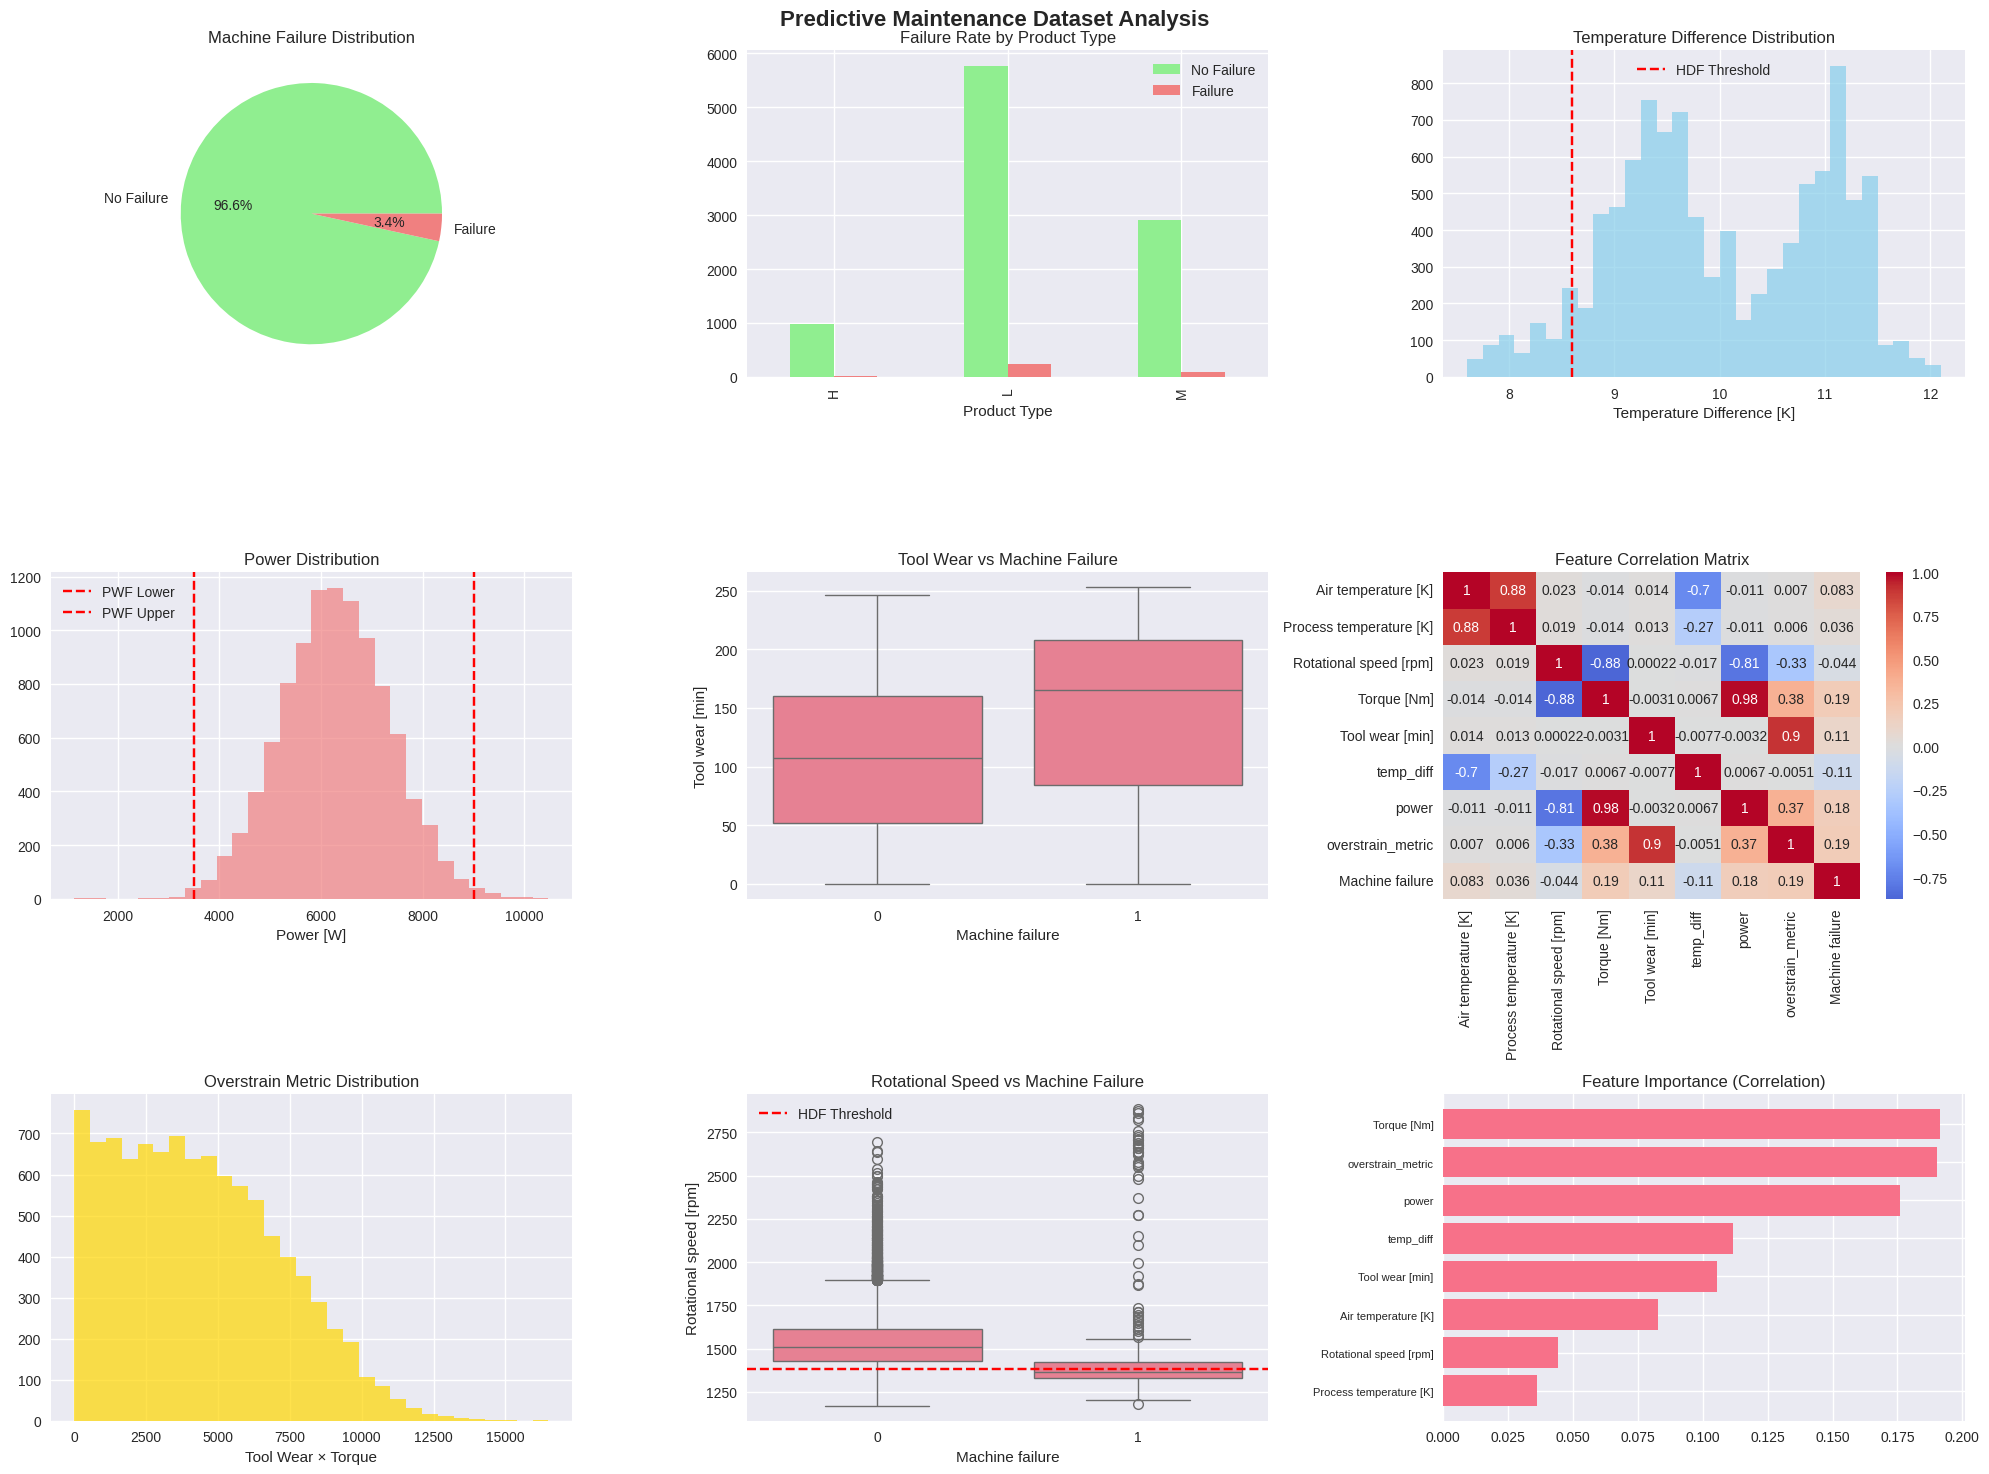


🔧 Preparing Features for Modeling...
✅ Selected 18 features for modeling
📊 Class distribution: {0: 9661, 1: 339}

🤖 Training and Selecting Best Model...
🏆 Best Model Selected: Random Forest
📊 Performance - Accuracy: 0.9800, F1: 0.7436, ROC-AUC: 0.9696

📊 MODEL PERFORMANCE SUMMARY
🏆 Best Model: Random Forest
🎯 Accuracy: 98.00%
📈 F1-Score: 0.7436
📊 ROC-AUC: 0.9696

🔍 DETAILED RESULTS:
✅ True Negatives (Correctly predicted No Failure): 1902
❌ False Positives (Incorrectly predicted Failure): 30
❌ False Negatives (Missed Failures): 10
✅ True Positives (Correctly predicted Failure): 58

📋 KEY METRICS:
🔍 Precision (When predicting failure, how often correct): 65.91%
🎯 Recall (How many actual failures detected): 85.29%


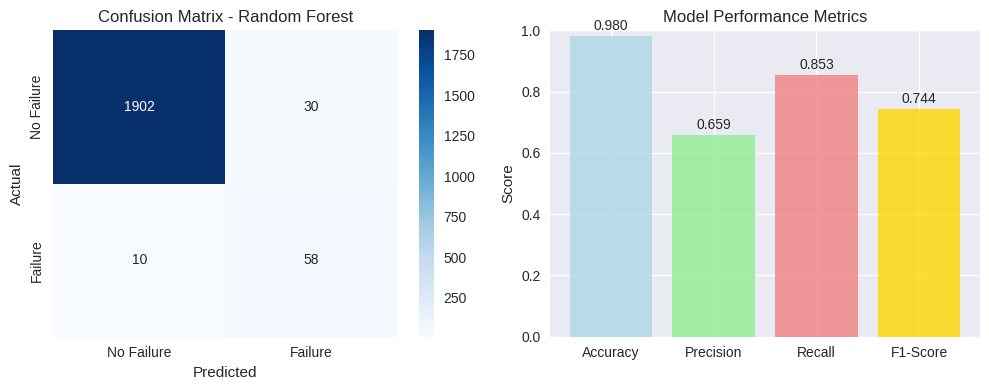


🔍 Feature Importance Analysis...

📝 Enter input data for machine failure prediction:
🌡️  Air Temperature [K]: 298.9
🔥 Process Temperature [K]: 309
⚙️  Rotational Speed [rpm]: 1410
🔧 Torque [Nm]: 65.7
⏰ Tool Wear [min]: 191
📦 Product Type (L / M / H): L

🔮 MACHINE FAILURE PREDICTION
📋 INPUT PARAMETERS:
   🌡️  Air Temperature: 298.9 K
   🔥 Process Temperature: 309.0 K
   ⚙️  Rotational Speed: 1410.0 rpm
   🔧 Torque: 65.7 Nm
   ⏰ Tool Wear: 191.0 minutes
   📦 Product Type: L

🔍 CALCULATED METRICS:
   🌡️  Temperature Difference: 10.1 K
   ⚡ Power: 9701 W
   💪 Overstrain Metric: 12549 min·Nm

🎯 PREDICTION RESULT:
🚨 FAILURE EXPECTED!
📊 Failure Probability: 97.0%
🎚️  Risk Level: 🔴 CRITICAL
🎯 Confidence: 97.0%

⚠️  IDENTIFIED RISK FACTORS:
   ⚠️  Power Failure Risk
   ⚠️  Overstrain Risk

💡 RECOMMENDATIONS:
   🔧 Schedule immediate maintenance
   🛑 Consider stopping operation
   📋 Inspect critical components


In [ ]:
# Predictive Maintenance: Machine Failure Prediction
# Dataset: AI4I 2020 Predictive Maintenance Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class PredictiveMaintenanceML:
    def __init__(self):
        self.models = {}
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_names = []
        self.best_model = None
        self.best_model_name = ""

    def load_data(self, filepath):
        """Load dataset"""
        print("🔍 Loading Dataset...")

        # Load data
        self.df = pd.read_csv(filepath)
        print(f"✅ Dataset loaded successfully - Shape: {self.df.shape}")

        return self.df

    def feature_engineering(self):
        """Create new features based on domain knowledge"""
        print("\n🔧 Feature Engineering...")

        # Create a copy for feature engineering
        df_engineered = self.df.copy()

        # 1. Temperature difference (critical for Heat Dissipation Failure)
        df_engineered['temp_diff'] = df_engineered['Process temperature [K]'] - df_engineered['Air temperature [K]']

        # 2. Power calculation (critical for Power Failure)
        # Power = Torque × Angular velocity (in rad/s)
        # Angular velocity = RPM × 2π/60
        df_engineered['power'] = (df_engineered['Torque [Nm]'] *
                                 df_engineered['Rotational speed [rpm]'] * 2 * np.pi / 60)

        # 3. Overstrain metric (critical for Overstrain Failure)
        df_engineered['overstrain_metric'] = df_engineered['Tool wear [min]'] * df_engineered['Torque [Nm]']

        # 4. Tool wear risk zones
        df_engineered['tool_wear_risk'] = pd.cut(df_engineered['Tool wear [min]'],
                                                bins=[0, 100, 180, 220, 300],
                                                labels=['Low', 'Medium', 'High', 'Critical'])

        # 5. Speed categories
        df_engineered['speed_category'] = pd.cut(df_engineered['Rotational speed [rpm]'],
                                               bins=[0, 1380, 1600, 2000, 3000],
                                               labels=['Low', 'Medium', 'High', 'Very_High'])

        # 6. Process efficiency ratio
        df_engineered['efficiency_ratio'] = df_engineered['power'] / df_engineered['Process temperature [K]']

        # 7. Encode categorical variables
        df_engineered['Type_encoded'] = self.label_encoder.fit_transform(df_engineered['Type'])

        # Convert categorical features to dummy variables
        df_engineered = pd.get_dummies(df_engineered, columns=['tool_wear_risk', 'speed_category'],
                                     prefix=['wear_risk', 'speed_cat'])

        self.df_engineered = df_engineered
        print(f"✅ Feature engineering complete. New shape: {df_engineered.shape}")

        return df_engineered

    def visualize_data(self):
        """Create comprehensive visualizations"""
        print("\n📊 Creating Visualizations...")

        # Set up the plotting area
        fig, axes = plt.subplots(3, 3, figsize=(20, 15))
        fig.suptitle('Predictive Maintenance Dataset Analysis', fontsize=16, fontweight='bold')

        # 1. Failure distribution
        failure_counts = self.df['Machine failure'].value_counts()
        axes[0,0].pie(failure_counts.values, labels=['No Failure', 'Failure'], autopct='%1.1f%%',
                     colors=['lightgreen', 'lightcoral'])
        axes[0,0].set_title('Machine Failure Distribution')

        # 2. Failure by Type
        failure_by_type = pd.crosstab(self.df['Type'], self.df['Machine failure'])
        failure_by_type.plot(kind='bar', ax=axes[0,1], color=['lightgreen', 'lightcoral'])
        axes[0,1].set_title('Failure Rate by Product Type')
        axes[0,1].set_xlabel('Product Type')
        axes[0,1].legend(['No Failure', 'Failure'])

        # 3. Temperature difference distribution
        axes[0,2].hist(self.df_engineered['temp_diff'], bins=30, alpha=0.7, color='skyblue')
        axes[0,2].axvline(8.6, color='red', linestyle='--', label='HDF Threshold')
        axes[0,2].set_title('Temperature Difference Distribution')
        axes[0,2].set_xlabel('Temperature Difference [K]')
        axes[0,2].legend()

        # 4. Power distribution
        axes[1,0].hist(self.df_engineered['power'], bins=30, alpha=0.7, color='lightcoral')
        axes[1,0].axvline(3500, color='red', linestyle='--', label='PWF Lower')
        axes[1,0].axvline(9000, color='red', linestyle='--', label='PWF Upper')
        axes[1,0].set_title('Power Distribution')
        axes[1,0].set_xlabel('Power [W]')
        axes[1,0].legend()

        # 5. Tool wear vs Failure
        sns.boxplot(data=self.df, x='Machine failure', y='Tool wear [min]', ax=axes[1,1])
        axes[1,1].set_title('Tool Wear vs Machine Failure')

        # 6. Correlation heatmap
        numeric_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
                       'Torque [Nm]', 'Tool wear [min]', 'temp_diff', 'power', 'overstrain_metric']
        correlation_matrix = self.df_engineered[numeric_cols + ['Machine failure']].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
        axes[1,2].set_title('Feature Correlation Matrix')

        # 7. Overstrain metric distribution
        axes[2,0].hist(self.df_engineered['overstrain_metric'], bins=30, alpha=0.7, color='gold')
        axes[2,0].set_title('Overstrain Metric Distribution')
        axes[2,0].set_xlabel('Tool Wear × Torque')

        # 8. Rotational speed vs failure
        sns.boxplot(data=self.df, x='Machine failure', y='Rotational speed [rpm]', ax=axes[2,1])
        axes[2,1].axhline(1380, color='red', linestyle='--', label='HDF Threshold')
        axes[2,1].set_title('Rotational Speed vs Machine Failure')
        axes[2,1].legend()

        # 9. Feature importance preview (using correlation with target)
        feature_importance = abs(correlation_matrix['Machine failure'].drop('Machine failure')).sort_values(ascending=True)
        axes[2,2].barh(range(len(feature_importance)), feature_importance.values)
        axes[2,2].set_yticks(range(len(feature_importance)))
        axes[2,2].set_yticklabels(feature_importance.index, fontsize=8)
        axes[2,2].set_title('Feature Importance (Correlation)')

        plt.tight_layout()
        plt.show()

    def prepare_features(self):
        """Prepare features for modeling"""
        print("\n🔧 Preparing Features for Modeling...")

        # Select features for modeling
        feature_cols = [
            'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
            'Torque [Nm]', 'Tool wear [min]', 'Type_encoded',
            'temp_diff', 'power', 'overstrain_metric', 'efficiency_ratio'
        ]

        # Add dummy variables
        dummy_cols = [col for col in self.df_engineered.columns if 'wear_risk_' in col or 'speed_cat_' in col]
        feature_cols.extend(dummy_cols)

        # Prepare X and y
        X = self.df_engineered[feature_cols]
        y = self.df_engineered['Machine failure']

        self.feature_names = feature_cols

        print(f"✅ Selected {len(feature_cols)} features for modeling")
        print(f"📊 Class distribution: {y.value_counts().to_dict()}")

        return X, y

    def train_best_model(self, X, y, test_size=0.2, random_state=42):
        """Train and select the best performing model"""
        print("\n🤖 Training and Selecting Best Model...")

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Store test data for later use
        self.X_test = X_test_scaled
        self.y_test = y_test

        # Define models for quick evaluation
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=random_state),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=random_state),
            'Logistic Regression': LogisticRegression(random_state=random_state, max_iter=1000)
        }

        # Quick evaluation to find best model
        best_f1 = 0
        best_model_name = ""

        for name, model in models.items():
            # Handle class imbalance with SMOTE
            smote = SMOTE(random_state=random_state)
            X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

            # Train model
            model.fit(X_train_balanced, y_train_balanced)

            # Quick evaluation
            y_pred = model.predict(X_test_scaled)
            f1 = f1_score(y_test, y_pred)

            if f1 > best_f1:
                best_f1 = f1
                best_model_name = name
                self.best_model = model

        self.best_model_name = best_model_name

        # Final evaluation of best model
        y_pred = self.best_model.predict(X_test_scaled)
        y_pred_proba = self.best_model.predict_proba(X_test_scaled)[:, 1]

        # Calculate final metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1_final = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        self.model_performance = {
            'accuracy': accuracy,
            'f1_score': f1_final,
            'roc_auc': roc_auc,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

        print(f"🏆 Best Model Selected: {best_model_name}")
        print(f"📊 Performance - Accuracy: {accuracy:.4f}, F1: {f1_final:.4f}, ROC-AUC: {roc_auc:.4f}")

        return self.best_model

    def show_model_performance(self):
        """Display model performance clearly"""
        print("\n📊 MODEL PERFORMANCE SUMMARY")
        print("=" * 50)
        print(f"🏆 Best Model: {self.best_model_name}")
        print(f"🎯 Accuracy: {self.model_performance['accuracy']:.2%}")
        print(f"📈 F1-Score: {self.model_performance['f1_score']:.4f}")
        print(f"📊 ROC-AUC: {self.model_performance['roc_auc']:.4f}")

        # Confusion Matrix Details
        cm = confusion_matrix(self.y_test, self.model_performance['predictions'])
        tn, fp, fn, tp = cm.ravel()

        print(f"\n🔍 DETAILED RESULTS:")
        print(f"✅ True Negatives (Correctly predicted No Failure): {tn}")
        print(f"❌ False Positives (Incorrectly predicted Failure): {fp}")
        print(f"❌ False Negatives (Missed Failures): {fn}")
        print(f"✅ True Positives (Correctly predicted Failure): {tp}")

        # Calculate additional metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        print(f"\n📋 KEY METRICS:")
        print(f"🔍 Precision (When predicting failure, how often correct): {precision:.2%}")
        print(f"🎯 Recall (How many actual failures detected): {recall:.2%}")

        # Simple visualization
        plt.figure(figsize=(10, 4))

        # Confusion Matrix
        plt.subplot(1, 2, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No Failure', 'Failure'],
                   yticklabels=['No Failure', 'Failure'])
        plt.title(f'Confusion Matrix - {self.best_model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        # Performance Metrics Bar Chart
        plt.subplot(1, 2, 2)
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        values = [self.model_performance['accuracy'], precision, recall, self.model_performance['f1_score']]
        colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold']

        bars = plt.bar(metrics, values, color=colors, alpha=0.8)
        plt.title('Model Performance Metrics')
        plt.ylabel('Score')
        plt.ylim(0, 1)

        # Add value labels on bars
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def feature_importance_analysis(self):
        """Analyze feature importance for tree-based models"""
        print("\n🔍 Feature Importance Analysis...")

        # Get feature importance from Random Forest
        if 'Random Forest' in self.models:
            rf_model = self.models['Random Forest']['model']
            feature_importance = pd.DataFrame({
                'feature': self.feature_names,
                'importance': rf_model.feature_importances_
            }).sort_values('importance', ascending=False)

            print("🌳 Random Forest Feature Importance:")
            print(feature_importance.head(10))

            # Plot feature importance
            plt.figure(figsize=(10, 8))
            sns.barplot(data=feature_importance.head(10), y='feature', x='importance', palette='viridis')
            plt.title('Top 10 Most Important Features (Random Forest)')
            plt.xlabel('Importance Score')
            plt.tight_layout()
            plt.show()

            return feature_importance

    def predict_maintenance(self, input_data):
        """Make predictions for new data with clear results"""
        """
        Expected input_data format (dict):
        {
            'Air temperature [K]': 298.1,
            'Process temperature [K]': 308.6,
            'Rotational speed [rpm]': 1551,
            'Torque [Nm]': 42.8,
            'Tool wear [min]': 0,
            'Type': 'M'  # L, M, or H
        }
        """
        print("\n" + "="*60)
        print("🔮 MACHINE FAILURE PREDICTION")
        print("="*60)

        # Convert input to DataFrame
        input_df = pd.DataFrame([input_data])

        # Apply same feature engineering
        input_df['Type_encoded'] = self.label_encoder.transform(input_df['Type'])
        input_df['temp_diff'] = input_df['Process temperature [K]'] - input_df['Air temperature [K]']
        input_df['power'] = (input_df['Torque [Nm]'] * input_df['Rotational speed [rpm]'] * 2 * np.pi / 60)
        input_df['overstrain_metric'] = input_df['Tool wear [min]'] * input_df['Torque [Nm]']
        input_df['efficiency_ratio'] = input_df['power'] / input_df['Process temperature [K]']

        # Create dummy variables (set all to 0 for simplicity, can be enhanced)
        for col in self.feature_names:
            if col not in input_df.columns:
                input_df[col] = 0

        # Select and order features
        X_input = input_df[self.feature_names]

        # Scale features
        X_input_scaled = self.scaler.transform(X_input)

        # Make prediction
        prediction = self.best_model.predict(X_input_scaled)[0]
        probability = self.best_model.predict_proba(X_input_scaled)[0]

        # Display input parameters clearly
        print("📋 INPUT PARAMETERS:")
        print(f"   🌡️  Air Temperature: {input_data['Air temperature [K]']:.1f} K")
        print(f"   🔥 Process Temperature: {input_data['Process temperature [K]']:.1f} K")
        print(f"   ⚙️  Rotational Speed: {input_data['Rotational speed [rpm]']} rpm")
        print(f"   🔧 Torque: {input_data['Torque [Nm]']:.1f} Nm")
        print(f"   ⏰ Tool Wear: {input_data['Tool wear [min]']} minutes")
        print(f"   📦 Product Type: {input_data['Type']}")

        # Calculated metrics
        temp_diff = input_data['Process temperature [K]'] - input_data['Air temperature [K]']
        power = input_data['Torque [Nm]'] * input_data['Rotational speed [rpm]'] * 2 * np.pi / 60
        overstrain = input_data['Tool wear [min]'] * input_data['Torque [Nm]']

        print(f"\n🔍 CALCULATED METRICS:")
        print(f"   🌡️  Temperature Difference: {temp_diff:.1f} K")
        print(f"   ⚡ Power: {power:.0f} W")
        print(f"   💪 Overstrain Metric: {overstrain:.0f} min·Nm")

        # Risk analysis
        risk_factors = []
        if temp_diff < 8.6 and input_data['Rotational speed [rpm]'] < 1380:
            risk_factors.append("⚠️  Heat Dissipation Risk")
        if power < 3500 or power > 9000:
            risk_factors.append("⚠️  Power Failure Risk")
        if input_data['Tool wear [min]'] > 200:
            risk_factors.append("⚠️  Tool Wear Risk")

        # Overstrain thresholds by type
        overstrain_limits = {'L': 11000, 'M': 12000, 'H': 13000}
        if overstrain > overstrain_limits.get(input_data['Type'], 12000):
            risk_factors.append("⚠️  Overstrain Risk")

        # Main prediction result
        print(f"\n🎯 PREDICTION RESULT:")
        print("="*40)

        failure_prob = probability[1]

        if prediction == 1:
            print("🚨 FAILURE EXPECTED!")
            status_color = "RED"
        else:
            print("✅ NO FAILURE EXPECTED")
            status_color = "GREEN"

        print(f"📊 Failure Probability: {failure_prob:.1%}")

        # Risk level classification
        if failure_prob >= 0.8:
            risk_level = "🔴 CRITICAL"
        elif failure_prob >= 0.6:
            risk_level = "🟠 HIGH"
        elif failure_prob >= 0.3:
            risk_level = "🟡 MEDIUM"
        else:
            risk_level = "🟢 LOW"

        print(f"🎚️  Risk Level: {risk_level}")
        print(f"🎯 Confidence: {max(probability):.1%}")

        # Risk factors
        if risk_factors:
            print(f"\n⚠️  IDENTIFIED RISK FACTORS:")
            for factor in risk_factors:
                print(f"   {factor}")
        else:
            print(f"\n✅ NO MAJOR RISK FACTORS IDENTIFIED")

        # Recommendations
        print(f"\n💡 RECOMMENDATIONS:")
        if prediction == 1:
            print("   🔧 Schedule immediate maintenance")
            print("   🛑 Consider stopping operation")
            print("   📋 Inspect critical components")
        else:
            if failure_prob > 0.3:
                print("   👀 Monitor closely")
                print("   📅 Schedule preventive maintenance")
            else:
                print("   ✅ Continue normal operation")
                print("   📊 Regular monitoring recommended")

        print("="*60)

        # Return structured result
        result = {
            'prediction': 'FAILURE EXPECTED' if prediction == 1 else 'NO FAILURE',
            'failure_probability': failure_prob,
            'risk_level': risk_level.split()[1],  # Remove emoji for programmatic use
            'confidence': max(probability),
            'risk_factors': risk_factors,
            'calculated_metrics': {
                'temp_diff': temp_diff,
                'power': power,
                'overstrain_metric': overstrain
            }
        }

        return result

# Example usage and demonstration
if __name__ == "__main__":
    # Initialize the ML pipeline
    pm_ml = PredictiveMaintenanceML()

    # Note: Replace 'your_dataset.csv' with the actual path to your dataset
    print("🚀 Starting Predictive Maintenance ML Pipeline")
    print("=" * 60)

    # Uncomment the following lines when you have the dataset

    # Load and explore data
    df = pm_ml.load_data('/content/ai4i2020.csv')

    # Feature engineering
    df_engineered = pm_ml.feature_engineering()

    # Create visualizations
    pm_ml.visualize_data()

    # Prepare features
    X, y = pm_ml.prepare_features()

    # Train models
    results = pm_ml.train_best_model(X, y)

    # Evaluate models
    pm_ml.show_model_performance()

    # Feature importance analysis
    feature_importance = pm_ml.feature_importance_analysis()
   # Take sample input from user
    print("\n📝 Enter input data for machine failure prediction:")
    sample_input = {
        'Air temperature [K]': float(input("🌡️  Air Temperature [K]: ")),
        'Process temperature [K]': float(input("🔥 Process Temperature [K]: ")),
        'Rotational speed [rpm]': float(input("⚙️  Rotational Speed [rpm]: ")),
        'Torque [Nm]': float(input("🔧 Torque [Nm]: ")),
        'Tool wear [min]': float(input("⏰ Tool Wear [min]: ")),
        'Type': input("📦 Product Type (L / M / H): ").strip().upper()
    }

    prediction_result = pm_ml.predict_maintenance(sample_input)




Starting Predictive Maintenance ML Pipeline
Loading Dataset...
Dataset loaded successfully - Shape: (10000, 14)

Feature Engineering...
Feature engineering complete. New shape: (10000, 27)

Creating Visualizations...


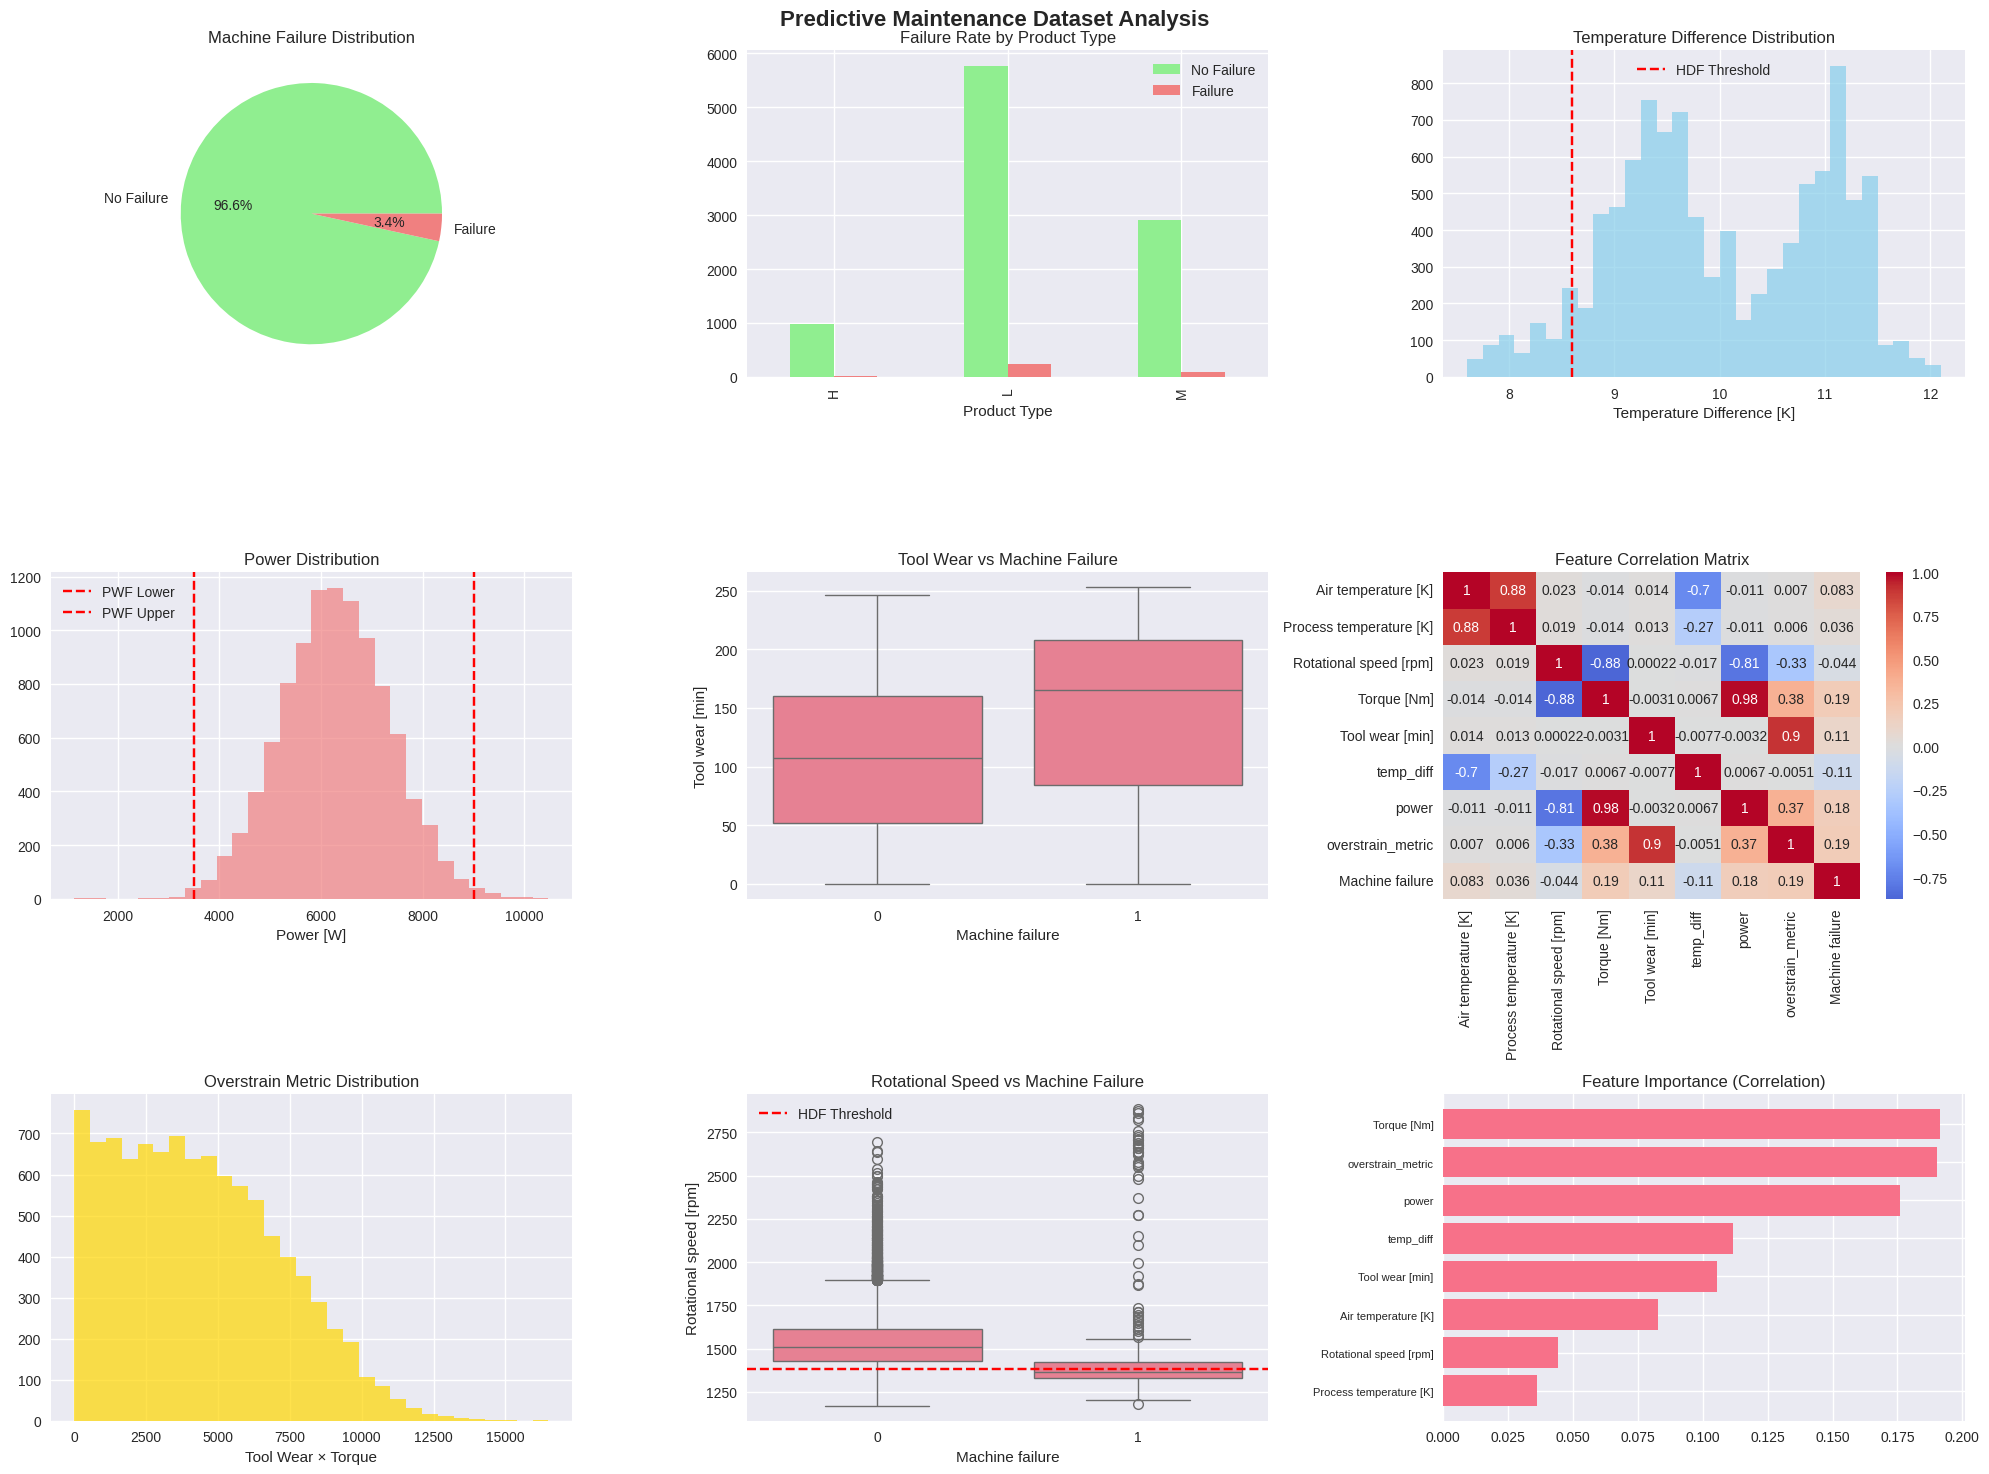


Preparing Features for Modeling...
Selected 18 features for modeling
Class distribution: {0: 9661, 1: 339}

Training and Selecting Best Model...
Best Model Selected: Random Forest
Performance - Accuracy: 0.9800, F1: 0.7436, ROC-AUC: 0.9696

MODEL PERFORMANCE SUMMARY
Best Model: Random Forest
Accuracy: 98.00%
F1-Score: 0.7436
ROC-AUC: 0.9696

DETAILED RESULTS:
True Negatives (Correctly predicted No Failure): 1902
False Positives (Incorrectly predicted Failure): 30
False Negatives (Missed Failures): 10
True Positives (Correctly predicted Failure): 58

KEY METRICS:
Precision (When predicting failure, how often correct): 65.91%
Recall (How many actual failures detected): 85.29%


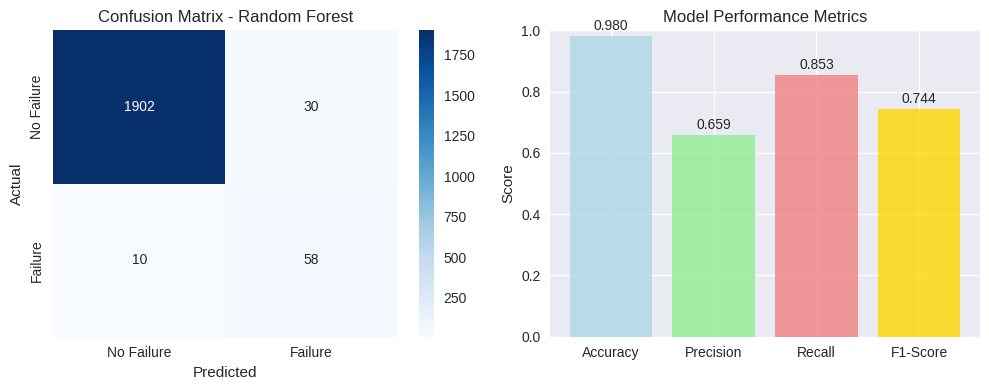


Feature Importance Analysis...

Enter input data for machine failure prediction:
Air Temperature [K]: 298.1
Process Temperature [K]: 308.6
Rotational Speed [rpm]: 1551
Torque [Nm]: 42.8
Tool Wear [min]: 0
Product Type (L / M / H): M

MACHINE FAILURE PREDICTION
INPUT PARAMETERS:
   Air Temperature: 298.1 K
   Process Temperature: 308.6 K
   Rotational Speed: 1551.0 rpm
   Torque: 42.8 Nm
   Tool Wear: 0.0 minutes
   Product Type: M

CALCULATED METRICS:
   Temperature Difference: 10.5 K
   Power: 6952 W
   Overstrain Metric: 0 min·Nm

PREDICTION RESULT:
NO FAILURE EXPECTED
Failure Probability: 2.0%
Risk Level: LOW
Confidence: 98.0%

NO MAJOR RISK FACTORS IDENTIFIED

RECOMMENDATIONS:
   Continue normal operation
   Regular monitoring recommended


In [ ]:
# Predictive Maintenance: Machine Failure Prediction
# Dataset: AI4I 2020 Predictive Maintenance Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class PredictiveMaintenanceML:
    def __init__(self):
        self.models = {}
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_names = []
        self.best_model = None
        self.best_model_name = ""

    def load_data(self, filepath):
        print("Loading Dataset...")
        self.df = pd.read_csv(filepath)
        print(f"Dataset loaded successfully - Shape: {self.df.shape}")
        return self.df

    def feature_engineering(self):
        print("\nFeature Engineering...")
        df_engineered = self.df.copy()

        df_engineered['temp_diff'] = df_engineered['Process temperature [K]'] - df_engineered['Air temperature [K]']
        df_engineered['power'] = (df_engineered['Torque [Nm]'] * df_engineered['Rotational speed [rpm]'] * 2 * np.pi / 60)
        df_engineered['overstrain_metric'] = df_engineered['Tool wear [min]'] * df_engineered['Torque [Nm]']
        df_engineered['tool_wear_risk'] = pd.cut(df_engineered['Tool wear [min]'], bins=[0, 100, 180, 220, 300], labels=['Low', 'Medium', 'High', 'Critical'])
        df_engineered['speed_category'] = pd.cut(df_engineered['Rotational speed [rpm]'], bins=[0, 1380, 1600, 2000, 3000], labels=['Low', 'Medium', 'High', 'Very_High'])
        df_engineered['efficiency_ratio'] = df_engineered['power'] / df_engineered['Process temperature [K]']
        df_engineered['Type_encoded'] = self.label_encoder.fit_transform(df_engineered['Type'])
        df_engineered = pd.get_dummies(df_engineered, columns=['tool_wear_risk', 'speed_category'], prefix=['wear_risk', 'speed_cat'])

        self.df_engineered = df_engineered
        print(f"Feature engineering complete. New shape: {df_engineered.shape}")
        return df_engineered

    def visualize_data(self):
        print("\nCreating Visualizations...")
        fig, axes = plt.subplots(3, 3, figsize=(20, 15))
        fig.suptitle('Predictive Maintenance Dataset Analysis', fontsize=16, fontweight='bold')

        failure_counts = self.df['Machine failure'].value_counts()
        axes[0,0].pie(failure_counts.values, labels=['No Failure', 'Failure'], autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
        axes[0,0].set_title('Machine Failure Distribution')

        failure_by_type = pd.crosstab(self.df['Type'], self.df['Machine failure'])
        failure_by_type.plot(kind='bar', ax=axes[0,1], color=['lightgreen', 'lightcoral'])
        axes[0,1].set_title('Failure Rate by Product Type')
        axes[0,1].set_xlabel('Product Type')
        axes[0,1].legend(['No Failure', 'Failure'])

        axes[0,2].hist(self.df_engineered['temp_diff'], bins=30, alpha=0.7, color='skyblue')
        axes[0,2].axvline(8.6, color='red', linestyle='--', label='HDF Threshold')
        axes[0,2].set_title('Temperature Difference Distribution')
        axes[0,2].set_xlabel('Temperature Difference [K]')
        axes[0,2].legend()

        axes[1,0].hist(self.df_engineered['power'], bins=30, alpha=0.7, color='lightcoral')
        axes[1,0].axvline(3500, color='red', linestyle='--', label='PWF Lower')
        axes[1,0].axvline(9000, color='red', linestyle='--', label='PWF Upper')
        axes[1,0].set_title('Power Distribution')
        axes[1,0].set_xlabel('Power [W]')
        axes[1,0].legend()

        sns.boxplot(data=self.df, x='Machine failure', y='Tool wear [min]', ax=axes[1,1])
        axes[1,1].set_title('Tool Wear vs Machine Failure')

        numeric_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'temp_diff', 'power', 'overstrain_metric']
        correlation_matrix = self.df_engineered[numeric_cols + ['Machine failure']].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
        axes[1,2].set_title('Feature Correlation Matrix')

        axes[2,0].hist(self.df_engineered['overstrain_metric'], bins=30, alpha=0.7, color='gold')
        axes[2,0].set_title('Overstrain Metric Distribution')
        axes[2,0].set_xlabel('Tool Wear × Torque')

        sns.boxplot(data=self.df, x='Machine failure', y='Rotational speed [rpm]', ax=axes[2,1])
        axes[2,1].axhline(1380, color='red', linestyle='--', label='HDF Threshold')
        axes[2,1].set_title('Rotational Speed vs Machine Failure')
        axes[2,1].legend()

        feature_importance = abs(correlation_matrix['Machine failure'].drop('Machine failure')).sort_values(ascending=True)
        axes[2,2].barh(range(len(feature_importance)), feature_importance.values)
        axes[2,2].set_yticks(range(len(feature_importance)))
        axes[2,2].set_yticklabels(feature_importance.index, fontsize=8)
        axes[2,2].set_title('Feature Importance (Correlation)')

        plt.tight_layout()
        plt.show()

    # Predictive Maintenance: Machine Failure Prediction
# Dataset: AI4I 2020 Predictive Maintenance Dataset

# ... [imports and initial class code already shown above] ...

    def prepare_features(self):
        print("\nPreparing Features for Modeling...")

        feature_cols = [
            'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
            'Torque [Nm]', 'Tool wear [min]', 'Type_encoded',
            'temp_diff', 'power', 'overstrain_metric', 'efficiency_ratio'
        ]

        dummy_cols = [col for col in self.df_engineered.columns if 'wear_risk_' in col or 'speed_cat_' in col]
        feature_cols.extend(dummy_cols)

        X = self.df_engineered[feature_cols]
        y = self.df_engineered['Machine failure']

        self.feature_names = feature_cols

        print(f"Selected {len(feature_cols)} features for modeling")
        print(f"Class distribution: {y.value_counts().to_dict()}")

        return X, y

    def train_best_model(self, X, y, test_size=0.2, random_state=42):
        print("\nTraining and Selecting Best Model...")

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        self.X_test = X_test_scaled
        self.y_test = y_test

        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=random_state),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=random_state),
            'Logistic Regression': LogisticRegression(random_state=random_state, max_iter=1000)
        }

        best_f1 = 0
        best_model_name = ""

        for name, model in models.items():
            smote = SMOTE(random_state=random_state)
            X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

            model.fit(X_train_balanced, y_train_balanced)

            y_pred = model.predict(X_test_scaled)
            f1 = f1_score(y_test, y_pred)

            if f1 > best_f1:
                best_f1 = f1
                best_model_name = name
                self.best_model = model

        self.best_model_name = best_model_name

        y_pred = self.best_model.predict(X_test_scaled)
        y_pred_proba = self.best_model.predict_proba(X_test_scaled)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        f1_final = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        self.model_performance = {
            'accuracy': accuracy,
            'f1_score': f1_final,
            'roc_auc': roc_auc,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

        print(f"Best Model Selected: {best_model_name}")
        print(f"Performance - Accuracy: {accuracy:.4f}, F1: {f1_final:.4f}, ROC-AUC: {roc_auc:.4f}")

        return self.best_model

    def show_model_performance(self):
        print("\nMODEL PERFORMANCE SUMMARY")
        print("=" * 50)
        print(f"Best Model: {self.best_model_name}")
        print(f"Accuracy: {self.model_performance['accuracy']:.2%}")
        print(f"F1-Score: {self.model_performance['f1_score']:.4f}")
        print(f"ROC-AUC: {self.model_performance['roc_auc']:.4f}")

        cm = confusion_matrix(self.y_test, self.model_performance['predictions'])
        tn, fp, fn, tp = cm.ravel()

        print(f"\nDETAILED RESULTS:")
        print(f"True Negatives (Correctly predicted No Failure): {tn}")
        print(f"False Positives (Incorrectly predicted Failure): {fp}")
        print(f"False Negatives (Missed Failures): {fn}")
        print(f"True Positives (Correctly predicted Failure): {tp}")

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        print(f"\nKEY METRICS:")
        print(f"Precision (When predicting failure, how often correct): {precision:.2%}")
        print(f"Recall (How many actual failures detected): {recall:.2%}")

        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No Failure', 'Failure'],
                   yticklabels=['No Failure', 'Failure'])
        plt.title(f'Confusion Matrix - {self.best_model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        plt.subplot(1, 2, 2)
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        values = [self.model_performance['accuracy'], precision, recall, self.model_performance['f1_score']]
        colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold']

        bars = plt.bar(metrics, values, color=colors, alpha=0.8)
        plt.title('Model Performance Metrics')
        plt.ylabel('Score')
        plt.ylim(0, 1)

        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def feature_importance_analysis(self):
        print("\nFeature Importance Analysis...")

        if 'Random Forest' in self.models:
            rf_model = self.models['Random Forest']['model']
            feature_importance = pd.DataFrame({
                'feature': self.feature_names,
                'importance': rf_model.feature_importances_
            }).sort_values('importance', ascending=False)

            print("Random Forest Feature Importance:")
            print(feature_importance.head(10))

            plt.figure(figsize=(10, 8))
            sns.barplot(data=feature_importance.head(10), y='feature', x='importance', palette='viridis')
            plt.title('Top 10 Most Important Features (Random Forest)')
            plt.xlabel('Importance Score')
            plt.tight_layout()
            plt.show()

            return feature_importance

    def predict_maintenance(self, input_data):
        print("\n" + "="*60)
        print("MACHINE FAILURE PREDICTION")
        print("="*60)

        input_df = pd.DataFrame([input_data])

        input_df['Type_encoded'] = self.label_encoder.transform(input_df['Type'])
        input_df['temp_diff'] = input_df['Process temperature [K]'] - input_df['Air temperature [K]']
        input_df['power'] = (input_df['Torque [Nm]'] * input_df['Rotational speed [rpm]'] * 2 * np.pi / 60)
        input_df['overstrain_metric'] = input_df['Tool wear [min]'] * input_df['Torque [Nm]']
        input_df['efficiency_ratio'] = input_df['power'] / input_df['Process temperature [K]']

        for col in self.feature_names:
            if col not in input_df.columns:
                input_df[col] = 0

        X_input = input_df[self.feature_names]
        X_input_scaled = self.scaler.transform(X_input)

        prediction = self.best_model.predict(X_input_scaled)[0]
        probability = self.best_model.predict_proba(X_input_scaled)[0]

        print("INPUT PARAMETERS:")
        print(f"   Air Temperature: {input_data['Air temperature [K]']:.1f} K")
        print(f"   Process Temperature: {input_data['Process temperature [K]']:.1f} K")
        print(f"   Rotational Speed: {input_data['Rotational speed [rpm]']} rpm")
        print(f"   Torque: {input_data['Torque [Nm]']:.1f} Nm")
        print(f"   Tool Wear: {input_data['Tool wear [min]']} minutes")
        print(f"   Product Type: {input_data['Type']}")

        temp_diff = input_data['Process temperature [K]'] - input_data['Air temperature [K]']
        power = input_data['Torque [Nm]'] * input_data['Rotational speed [rpm]'] * 2 * np.pi / 60
        overstrain = input_data['Tool wear [min]'] * input_data['Torque [Nm]']

        print(f"\nCALCULATED METRICS:")
        print(f"   Temperature Difference: {temp_diff:.1f} K")
        print(f"   Power: {power:.0f} W")
        print(f"   Overstrain Metric: {overstrain:.0f} min·Nm")

        risk_factors = []
        if temp_diff < 8.6 and input_data['Rotational speed [rpm]'] < 1380:
            risk_factors.append("Heat Dissipation Risk")
        if power < 3500 or power > 9000:
            risk_factors.append("Power Failure Risk")
        if input_data['Tool wear [min]'] > 200:
            risk_factors.append("Tool Wear Risk")

        overstrain_limits = {'L': 11000, 'M': 12000, 'H': 13000}
        if overstrain > overstrain_limits.get(input_data['Type'], 12000):
            risk_factors.append("Overstrain Risk")

        print(f"\nPREDICTION RESULT:")
        print("="*40)

        failure_prob = probability[1]

        if prediction == 1:
            print("FAILURE EXPECTED!")
        else:
            print("NO FAILURE EXPECTED")

        print(f"Failure Probability: {failure_prob:.1%}")

        if failure_prob >= 0.8:
            risk_level = "CRITICAL"
        elif failure_prob >= 0.6:
            risk_level = "HIGH"
        elif failure_prob >= 0.3:
            risk_level = "MEDIUM"
        else:
            risk_level = "LOW"

        print(f"Risk Level: {risk_level}")
        print(f"Confidence: {max(probability):.1%}")

        if risk_factors:
            print(f"\nIDENTIFIED RISK FACTORS:")
            for factor in risk_factors:
                print(f"   {factor}")
        else:
            print(f"\nNO MAJOR RISK FACTORS IDENTIFIED")

        print(f"\nRECOMMENDATIONS:")
        if prediction == 1:
            print("   Schedule immediate maintenance")
            print("   Consider stopping operation")
            print("   Inspect critical components")
        else:
            if failure_prob > 0.3:
                print("   Monitor closely")
                print("   Schedule preventive maintenance")
            else:
                print("   Continue normal operation")
                print("   Regular monitoring recommended")

        print("="*60)

        result = {
            'prediction': 'FAILURE EXPECTED' if prediction == 1 else 'NO FAILURE',
            'failure_probability': failure_prob,
            'risk_level': risk_level,
            'confidence': max(probability),
            'risk_factors': risk_factors,
            'calculated_metrics': {
                'temp_diff': temp_diff,
                'power': power,
                'overstrain_metric': overstrain
            }
        }

        return result

# Main script entry point
if __name__ == "__main__":
    pm_ml = PredictiveMaintenanceML()

    print("Starting Predictive Maintenance ML Pipeline")
    print("=" * 60)

    df = pm_ml.load_data('/content/ai4i2020.csv')
    df_engineered = pm_ml.feature_engineering()
    pm_ml.visualize_data()
    X, y = pm_ml.prepare_features()
    results = pm_ml.train_best_model(X, y)
    pm_ml.show_model_performance()
    feature_importance = pm_ml.feature_importance_analysis()

    print("\nEnter input data for machine failure prediction:")
    sample_input = {
        'Air temperature [K]': float(input("Air Temperature [K]: ")),
        'Process temperature [K]': float(input("Process Temperature [K]: ")),
        'Rotational speed [rpm]': float(input("Rotational Speed [rpm]: ")),
        'Torque [Nm]': float(input("Torque [Nm]: ")),
        'Tool wear [min]': float(input("Tool Wear [min]: ")),
        'Type': input("Product Type (L / M / H): ").strip().upper()
    }

    prediction_result = pm_ml.predict_maintenance(sample_input)

